In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.vision import *
import fastai.distributed
from pathlib import Path
import pdb
import re
import seaborn as sns
from IPython.display import SVG, display
from wand.image import Image as WImage
import wand
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# enter your path here
path = Path("../google-fonts-data")

In [4]:
out = []
for file in progress_bar(path.glob("**/*.svg"),total=113646):
    try:
        s = file.open().read()
        match = re.match(".*viewBox=\"0 0 (\d+) (\d+)\".*<path.*d=\"([^\"]*)\".*",s,flags=re.DOTALL)
        match2 = re.match(".*<g transform=\"matrix\(1 0 0 -1 0 (\d+)\)\">.*",s,flags=re.DOTALL)
        xform = 0
        if match2:
            xform = float(match2.group(1))
        out.append({"file": file, "path": match.group(3), "box_x": float(match.group(1)), "box_y": float(match.group(2)),"xform": xform})
    except:
        pass

In [5]:
svgDF = pd.DataFrame(out)
svgDF["png"] = svgDF.file.apply(lambda f: "/".join(f.parts[:-2]) + "/png/" + f.name[:-3] + "png")
exists = svgDF.png.apply(lambda f: Path(f).exists())
svgDF["label"] = svgDF.file.apply(lambda f: f.name[:-4])
svgDF["font"] = svgDF.file.apply(lambda f: f.parts[4])
svgDF = svgDF[exists]
svgDF.head()

,box_x,box_y,file,path,xform,png,label,font
0,535.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M32 34q0 10 1 16l2 17q3 27 11.5 38.5t24.5 11.5...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,one,asap
1,843.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M57 6.5q-13 8.5 -11 28.5l66 635q3 32 63 32h52q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$M,asap
2,489.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M15.5 24.5q-8.5 24.5 -8.5 48.5q0 15 8 24l257 3...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,z,asap
3,731.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M493.5 -105.5q-133.5 56.5 -258.5 112.5q-97 44 ...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$Q,asap
4,549.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M174 35l56 534h-158q-14 0 -20.5 9.5t-6.5 31.5q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$T,asap


In [ ]:
svgDF.to_pickle("svgdf.pkl")

In [4]:
svgDF = pickle.load(Path("svgdf.pkl").open("rb"))

In [5]:
def render_path(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
#     img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return st

In [6]:
def render_path_wand(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
    img = WImage(blob=str.encode(st),format="svg",width=64,height=64)
    return img

In [7]:
img = render_path_wand(svgDF.iloc[0].path,500,500)

In [8]:
img.size

(64, 64)

In [9]:
def wand_to_tensor(wimage):
    wimage.depth = 8
    wimage.background_color = wand.color.Color("white")
    wimage.alpha_channel = "remove"
    blob = wimage.make_blob(format="RGB")
    pixels = []
    for cursor in range(0,64*64*3,3):
        pixels.append((blob[cursor],
                       blob[cursor + 1],
                       blob[cursor + 2]))
    return torch.tensor(pixels).view(64,64,3).float().permute(2,0,1)[0] / 255.0

In [10]:
a = wand_to_tensor(render_path_wand(svgDF.iloc[0].path,500,500))

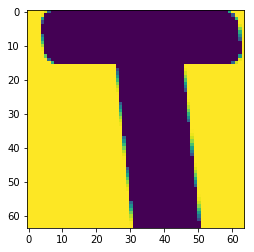

In [11]:
plt.imshow(a)

In [12]:
tool_dict = {"P": [], "M": ["x","y"], "m": ["x","y"], "L": ["x","y"], "l": ["x","y"], "H": ["x"], "h": ["x"], 
             "V": ["y"], "v": ["y"], "C": ["x","y","x","y","x","y"], "c": ["x","y","x","y","x","y"], "S": ["x","y","x","y"], 
             "s": ["x","y","x","y"], "Q": ["x","y","x","y"], "q": ["x","y","x","y"], "T": ["x","y"], "t": ["x","y"],
             "A": ["x","y","","","","x","y"], "a": ["x","y","","","","x","y"], "Z": [], "z": [], "START": [], "END": [], "PAD": []}


class TokenizeSVGProcessor(PreProcessor):
    
    def tokenize(self,path,box_x,box_y,xform,label):
        out = []
        for match in re.findall("([MmLlHhVvCcSsQqTtAaZz])([0-9\.\-\s]*)",path):
            token, pen = match
            td = tool_dict[token]
            xs = []
            for coord,x in zip(td,re.findall("((\-{0,1}\.[0-9]+)|(\-{0,1}[0-9]+\.{0,1}[0-9]*))\s*",pen)):
                x = x[0]
                if coord == "x" and token.isupper():
                    xs.append((float(x) + (box_y - box_x) / 2.0)/float(box_y))
                elif coord == "x":
                    xs.append(float(x)/float(box_y))
                elif coord == "y" and token.isupper():
                    value = (float(xform)-float(x))/float(box_y)
                    xs.append(value)
                elif coord == "y" and xform > 0:
                    value = -float(x)/float(box_y)
                    xs.append(value)
                else:
                    xs.append(float(x))
            assert len(td) == 0 or (len(xs) % len(td) == 0)
            if len(td) == 0:
                out.append((token,[-2.0]*4))
            else:
                for i in range(0,len(xs),len(td)):
                    s = xs[i:i+len(td)]
                    if token == "h":
                        s = [s[0], 0]
                        token = "l"
                    elif token == "v":
                        s = [0, s[0]]
                        token = "l"
                    if len(s) < 4: s += [-2.0] * (4-len(s))
                    out.append((token,s))
        return out,label
    
    def process(self, ds):
        ds.items = array([self.process_one(item) for item in ds.items])

    def process_one(self, item):
        return self.tokenize(*item)
    
class NumericalizeSVGProcessor(PreProcessor):
    def process_one(self,item):
        item,label = item
        return [(self.stoi["START"],[-2.0]*4)
               ] + [(self.stoi[t],n) for t,n in item] + [(self.stoi["END"],[-2.0]*4)],label
            
    def process(self,ds):
        if not hasattr(self,"vocab"):
            vocab = ["PAD"] + list("Mqlthzv") + ["START","END"]
            stoi = {s:i for i,s in enumerate(vocab)}
            self.vocab = ds.vocab = vocab
            self.stoi = ds.stoi = stoi
        super().process(ds)

In [13]:
class SVGList(ItemList):
    _processor = [TokenizeSVGProcessor,NumericalizeSVGProcessor]
    
    def get(self, i):
        item = self.items[i]
        item,label = item
        return [t[0] for t in item], np.stack([t[1] for t in item]), label

In [14]:
def npad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[LongTensor, LongTensor]:
    samples = to_data(samples)
    max_len = max([len(s[1][0]) for s in samples])
    res_tokens = torch.zeros(len(samples), max_len).long() + pad_idx
    res_numbers = torch.zeros(len(samples),max_len, 4) - 2.0
    for i,s in enumerate(samples):
        res_tokens[i,:len(s[1][0])] = LongTensor(s[1][0])
        res_numbers[i,:len(s[1][0])] = FloatTensor(s[1][1])
    return torch.stack([s[0] for s in samples]), (res_tokens,res_numbers,torch.tensor([s[1][2] for s in samples]))

In [15]:
dataAE = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
          .split_none()
          .label_from_df(cols=["label"],label_cls=CategoryList)
          .transform(size=64)
          .databunch(bs=256))

In [16]:
bs = 64
svgDF["label_codes"] = svgDF.label.apply(lambda x: dataAE.train_ds.y.c2i[x])
data = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
        .filter_by_rand(0.01,seed=3442)
        .split_none()
        .label_from_df(cols=["path","box_x","box_y","xform","label_codes"],label_cls=SVGList)
        .transform(size=64)
        .databunch(bs=bs,collate_fn=npad_collate))

In [17]:
class UpBlock(nn.Module):
    def __init__(self, up_in_c:int,final_div:bool=True, blur:bool=False, leaky:float=None,self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(62,16)
        self.encoder = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        self.z_mean = nn.Linear(64*16,32)
        self.z_logvar = nn.Linear(64*16,32)
        
        self.z_to_dec = nn.Linear(32+16,128*16)
        
        nf = [128,64,32,16]
        #nf = [2048,1024,512,256,128]
        self.decoder = nn.Sequential(*[UpBlock(f, blur=(False if f != 32 else False)) for f in nf])
        self.final_conv = conv_layer(8, 1, ks=1, use_activ=False)
        
    def get_z(self,x,char_class,stoc=True):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        if stoc:
            z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        return z
    
    def forward(self,x,char_class):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        #if self.training:
        z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        ls = z
        
        z = self.z_to_dec(z)
        z = z.view(x.shape[0],128,4,4)
        
        return torch.sigmoid(self.final_conv(self.decoder(z))), mean, logvar, ls
        
class VAELoss(nn.Module):
    def forward(self, preds, target):
        rec, mean, logvar,_ = preds
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        self.kld = KLD / (rec.shape[0] * 64 * 64)
        self.bce = F.binary_cross_entropy(rec.view(rec.shape[0],-1),target.view(target.shape[0],-1))
        return self.bce + self.kld

class VAETrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothBCE, self.smoothKLD = SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["bce","kld"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {"last_input": (last_input,last_target), "last_target": last_input}
    
    def on_batch_end(self,**kwargs):
        self.smoothBCE.add_value(self.learn.loss_func.bce.item())
        self.smoothKLD.add_value(self.learn.loss_func.kld.item())
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothBCE.smooth,self.smoothKLD.smooth])

In [18]:
learnAE = Learner(dataAE,VAE(),loss_func=VAELoss(),callback_fns=[VAETrainer])

In [316]:
learnAE.fit_one_cycle(10,3e-3)

epoch,train_loss,valid_loss,bce,kld,time
0,0.579524,#na#,0.572824,0.006700,00:50
1,0.460622,#na#,0.452750,0.007871,00:50
2,0.408130,#na#,0.400676,0.007454,00:50
3,0.404144,#na#,0.396846,0.007298,00:50
4,0.402757,#na#,0.395628,0.007129,00:50
5,0.401554,#na#,0.394524,0.007030,00:50
6,0.400560,#na#,0.393602,0.006958,00:50
7,0.399875,#na#,0.392953,0.006921,00:50
8,0.399261,#na#,0.392345,0.006916,00:50
9,0.399036,#na#,0.392128,0.006908,00:50


In [317]:
learnAE.save("ae")

In [19]:
learnAE.load("ae");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
x,y = next(iter(dataAE.train_dl))

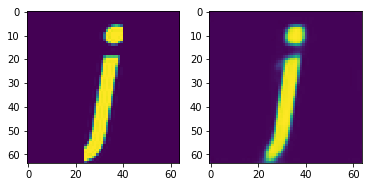

In [21]:
fig, axes = plt.subplots(1,2)
learnAE.model.eval()
rec = learnAE.model(x,y)[0]
axes[0].imshow(x[0].permute(1,2,0).squeeze())
axes[1].imshow(rec[0].permute(1,2,0).squeeze())

In [22]:
def dropout_mask(x:Tensor, sz:Collection[int], p:float):
    "Return a dropout mask of the same type as `x`, size `sz`, with probability `p` to cancel an element."
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class RNNDropout(nn.Module):
    "Dropout with probability `p` that is consistent on the seq_len dimension."

    def __init__(self, p:float=0.5):
        super().__init__()
        self.p=p

    def forward(self, x:Tensor)->Tensor:
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

class WeightDropout(nn.Module):
    "A module that warps another layer in which some weights will be replaced by 0 during training."

    def __init__(self, module:nn.Module, weight_p:float, layer_names:Collection[str]=['weight_hh_l0']):
        super().__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        "Apply dropout to the raw weights."
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args:ArgStar):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

    def reset(self):
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
        if hasattr(self.module, 'reset'): self.module.reset()

class EmbeddingDropout(nn.Module):
    "Apply dropout with probabily `embed_p` to an embedding layer `emb`."

    def __init__(self, emb:nn.Module, embed_p:float):
        super().__init__()
        self.emb,self.embed_p = emb,embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1

    def forward(self, words:LongTensor, scale:Optional[float]=None)->Tensor:
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0),1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            masked_embed = self.emb.weight * mask
        else: masked_embed = self.emb.weight
        if scale: masked_embed.mul_(scale)
        return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                           self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

class AWD_LSTM(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."

    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.3,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, bidir:bool=False):
        super().__init__()
        self.bs,self.emb_sz,self.n_hid,self.n_layers = 1,emb_sz,n_hid,n_layers
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
       
        self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, n_hid, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor, hs, from_embeddings:bool=False)->Tuple[Tensor,Tensor]:
        if from_embeddings: bs,sl,es = input.size()
        else: bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input if from_embeddings else self.encoder_dp(input))
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, (hs[0][[l]],hs[1][[l]]))
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        #self.hidden = to_detach(new_hidden, cpu=False)
        return outputs[-1], (torch.cat([x[0] for x in new_hidden]),torch.cat([x[1] for x in new_hidden]))

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def select_hidden(self, idxs):
        self.hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in self.hidden]
        self.bs = len(idxs)

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [75]:
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians, use_sigmoid=False, scale=1.0):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

        self.sigma = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.mu = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.use_sigmoid = use_sigmoid
        self.scale = scale

    def forward(self, minibatch):
        pi = self.pi(minibatch).view(minibatch.shape[0],minibatch.shape[1],self.out_features,self.num_gaussians)
        pi = torch.softmax(pi,dim=3)
        sigma = self.sigma(minibatch)
        if self.use_sigmoid:
            sigma = 0.1*torch.sigmoid(sigma) + 1e-5
        else:
            sigma = torch.exp(sigma) + 1e-5
        sigma = sigma.view(minibatch.shape[0], minibatch.shape[1], self.out_features,self.num_gaussians)
        mu = self.scale * torch.tanh(self.mu(minibatch))
        mu = mu.view(minibatch.shape[0],minibatch.shape[1], self.out_features, self.num_gaussians)
        return pi, sigma, mu

def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    ntarget = target.unsqueeze(-1)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(ntarget))
    #loss = torch.softmax(m.log_prob(ntarget),dim=2)
    loss = torch.sum(loss * pi, dim=3)
    #print((loss > 1).sum())
    loss = -torch.log(loss+1e-8)
    loss = loss[target != -2.0]
    return loss.mean()

In [64]:
def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    dist = torch.distributions.Categorical(pi)
    s = dist.sample().cuda()
    mu = torch.gather(mu,3,s.unsqueeze(-1)).squeeze(-1)
    sigma = torch.gather(sigma,3,s.unsqueeze(-1)).squeeze(-1)
    dist_n = torch.distributions.Normal(mu,sigma)
    return dist_n.sample().cuda()

In [76]:
class SVGDecoder(nn.Module):
    def __init__(self,num_tokens,vae_sd):
        super().__init__()
        self.vae = VAE()
        self.vae.load_state_dict(vae_sd)
        requires_grad(self.vae,False)
        self.token_emb = nn.Embedding(num_tokens,4)
        #self.rnn = nn.GRU(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        #self.rnn = nn.LSTM(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        self.rnn = AWD_LSTM(62,4+4+32+16,1024,4,0,input_p=0.0)
        self.z_to_hidden = nn.Linear(32+16,1024)
        self.token = nn.Linear(1024,num_tokens)
#         #self.pen = nn.Linear(1024,4)
        self.pen = MDN(1024,4,512,use_sigmoid=True)
        self.mask = torch.tensor([[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]]).cuda()
        
    def get_preds(self, png, char_class, use_mean=False):
        #z (bsx48)
        z = self.vae.get_z(png,char_class).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            if use_mean:
                pi,_,pen = self.pen(output)
                pi = torch.argmax(pi,dim=3,keepdim=True)
                pen = torch.gather(pen,3,pi).squeeze(-1)
            else:            
                pen = self.pen(output)
                pen = sample(*pen)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
            
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)

    def get_preds_mean(self, png, char_class):
        #z (bsx48)
        z = self.vae.get_z(png,char_class,False).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            pi,_,pen = self.pen(output)
            pi = torch.argmax(pi,dim=3,keepdim=True)
            pen = torch.gather(pen,3,pi).squeeze(-1)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)
    
    def get_preds_from_output(self,tokens,pi,sigma,mu):
        tokens = torch.argmax(tokens,dim=2)
        pi = torch.argmax(pi,dim=3,keepdim=True)
        mu = torch.gather(mu,3,pi).squeeze(-1)
        return tokens,mu
    
    def forward(self, png, char_class,tokens, pen, return_preds=True):
        z = self.vae.get_z(png,char_class).detach()
        tokens = self.token_emb(tokens)
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        r_in = torch.cat([tokens,pen,z.unsqueeze(1).expand(-1,tokens.shape[1],-1)],dim=2)
        #self.rnn.flatten_parameters()
        output, (hs,cs) = self.rnn(r_in,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        tokens = self.token(output)
        #pens = self.pen(output)
        #return tokens, pens
        pi,sigma,mu = self.pen(output)
        
        return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), self.get_preds_from_output(tokens,pi,sigma,mu), output
        #return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), output

In [80]:
class SVGDecoderLoss(nn.Module):
    def forward(self,preds,target_tokens,target_pen):
        tokens, pen, mpreds = preds
        mask = target_tokens != 0
        loss_token = 10.0*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens,reduction="none")[mask].mean()
        #loss_token = 10*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens)
        loss_pen = mdn_loss(*pen,target_pen)
        self.l_t = loss_token.item()
        self.l_p = loss_pen.item()
        with torch.no_grad():
            self.l_mse = F.mse_loss(mpreds[1][:,:-1],target_pen,reduction="none")[target_pen != -2.0].mean().item()
        #self.l_mse = 0.0
        return loss_token + loss_pen

class SVGDecoderTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothCE, self.smoothMDN, self.smoothMSE, self.smoothMu, self.smoothSigma = SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["ce","mdn", "mse", "mu", "sigma"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        self.last_target = last_target
        return {"last_input": (last_input,last_target[2],last_target[0],last_target[1]), "last_target": (last_target[0][:,1:],last_target[1][:,1:])}
    
    def on_loss_begin(self, last_output, **kwargs):
        self.smoothMu.add_value(last_output[1][2][self.last_target[1][:,1:].unsqueeze(-1).expand(-1,-1,-1,512)!=-2.0].abs().mean().item())
        self.smoothSigma.add_value(last_output[1][1][self.last_target[1][:,1:].unsqueeze(-1).expand(-1,-1,-1,512)!=-2.0].mean().item())
        self.out = last_output[3]
        return {"last_output": last_output[:3]}
    
    def on_backward_begin(self,last_loss, **kwargs):
        last_loss += 2.0 * self.out.float().pow(2).mean()
        return {"last_loss": last_loss}
       
    def on_batch_end(self,**kwargs):
        self.smoothCE.add_value(self.learn.loss_func.l_t)
        self.smoothMDN.add_value(self.learn.loss_func.l_p)
        self.smoothMSE.add_value(self.learn.loss_func.l_mse)
        
    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        #self.learn.save("svg_awd_full")
        return add_metrics(last_metrics,[self.smoothCE.smooth,self.smoothMDN.smooth,self.smoothMSE.smooth,self.smoothMu.smooth,self.smoothSigma.smooth])

In [81]:
learnSVG = Learner(data,SVGDecoder(len(data.vocab),learnAE.model.state_dict()),loss_func=SVGDecoderLoss(),callback_fns=[SVGDecoderTrainer])

In [82]:
learnSVG.fit_one_cycle(300,1e-3)

epoch,train_loss,valid_loss,ce,mdn,mse,mu,sigma,time
0,22.920372,#na#,22.662498,0.257877,0.025874,0.024779,0.050047,00:03
1,22.380997,#na#,22.161280,0.219712,0.027791,0.027778,0.050110,00:03
2,20.879801,#na#,20.770970,0.108826,0.056036,0.039920,0.050305,00:03
3,19.265619,#na#,19.291412,-0.025798,0.188670,0.066716,0.050925,00:03
4,17.928658,#na#,18.108990,-0.180340,0.253080,0.071945,0.051343,00:03
5,16.937042,#na#,17.248023,-0.310992,0.293322,0.071302,0.051550,00:03
6,16.107132,#na#,16.530759,-0.423635,0.351596,0.072481,0.051599,00:03
7,15.428781,#na#,15.955883,-0.527112,0.345816,0.075128,0.051450,00:03
8,14.840322,#na#,15.465605,-0.625294,0.277655,0.078786,0.051159,00:03
9,14.322803,#na#,15.029131,-0.706340,0.216325,0.082100,0.050636,00:03


In [83]:
learnSVG.save("svg_awd")

In [29]:
learnSVG.load("svg_awd_full");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type RNNDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoderLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/op

In [84]:
def get_pred_path(x,labels,mean=False,i=0):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
    out = []
    for t,p in zip(tools[i,1:-1],pens[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [85]:
def path_from_tensors(tools,pens,i=0):
    p = ""
    for t,pen in zip(tools[i,1:],pens[i,1:]):
        tool = data.vocab[t]
        if tool == "END": break
        pen = [str(int(np.rint(x.item()))) for x in pen*500]
        p = p + tool + " " + " ".join(pen[:len(tool_dict[tool])]) + " "
    return p

In [98]:
x,y = next(iter(data.train_dl))
labels = y[2]

In [99]:
po = path_from_tensors(y[0],y[1])
po

'M 373 362 q 0 8 -2 22 q -2 10 -12 14 t -22 5 q -22 0 -35 -12 t -15 -37 q -17 24 -40 36 t -46 12 q -32 0 -49 -16 t -16 -46 q 0 -8 0 -12 l 18 -179 q 2 -12 24 -12 l 6 0 q 23 0 22 12 l -17 170 q 0 2 0 7 q 0 32 34 32 q 18 0 38 -16 t 32 -52 l 15 -142 q 2 -12 24 -12 l 6 0 q 23 0 22 12 l -19 190 q -2 20 14 20 q 6 0 10 -2 t 6 -2 q 4 0 4 4 z  '

In [100]:
p = get_pred_path(x[[0]],labels[[0]])
p = p[:p.find("END")-1]
p
#render_path_wand(p,500,500)

'M 374 368 q 0 8 -2 23 q -1 10 -15 14 t -27 5 q -23 0 -35 -10 t -16 -32 q -15 18 -38 30 t -46 11 q -34 0 -49 -17 t -17 -46 q 0 2 0 -16 l 18 -177 q 2 -9 30 -11 l 5 0 q 15 0 22 12 l -17 183 q -1 4 0 6 q 0 14 34 32 q 19 0 35 -18 t 30 -40 l 17 -160 q 0 -12 26 -14 l 5 0 q 23 0 23 14 l -19 191 q -2 20 13 20 q 7 0 11 -2 t 6 -2 q 3 0 -8 6 z '

In [101]:
p_mean = get_pred_path(x[[0]],labels[[0]],mean=True)
#p_mean = p_mean[:p_mean.find("z")+1]
p_mean = p_mean[:p_mean.find("END")-1]
#p_mean = p_mean[:len(po)]
p_mean

'M 378 366 q 0 9 -2 22 q -2 11 -15 15 t -21 5 q -23 0 -35 -11 t -14 -39 q -15 16 -39 27 t -46 12 q -33 0 -49 -17 t -17 -47 q 0 -4 1 -18 l 18 -180 q 2 -13 28 -14 l 8 0 q 19 0 23 13 l -18 178 q -1 6 -1 8 q 0 22 34 33 q 19 0 35 -17 t 29 -46 l 16 -149 q 2 -13 27 -14 l 7 0 q 23 0 24 13 l -19 191 q -2 20 13 20 q 6 0 11 -2 t 7 -2 q 3 0 0 5 z '

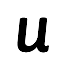

In [102]:
render_path_wand(path_from_tensors(y[0],y[1]),500,500)

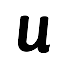

In [103]:
render_path_wand(p_mean,500,500)

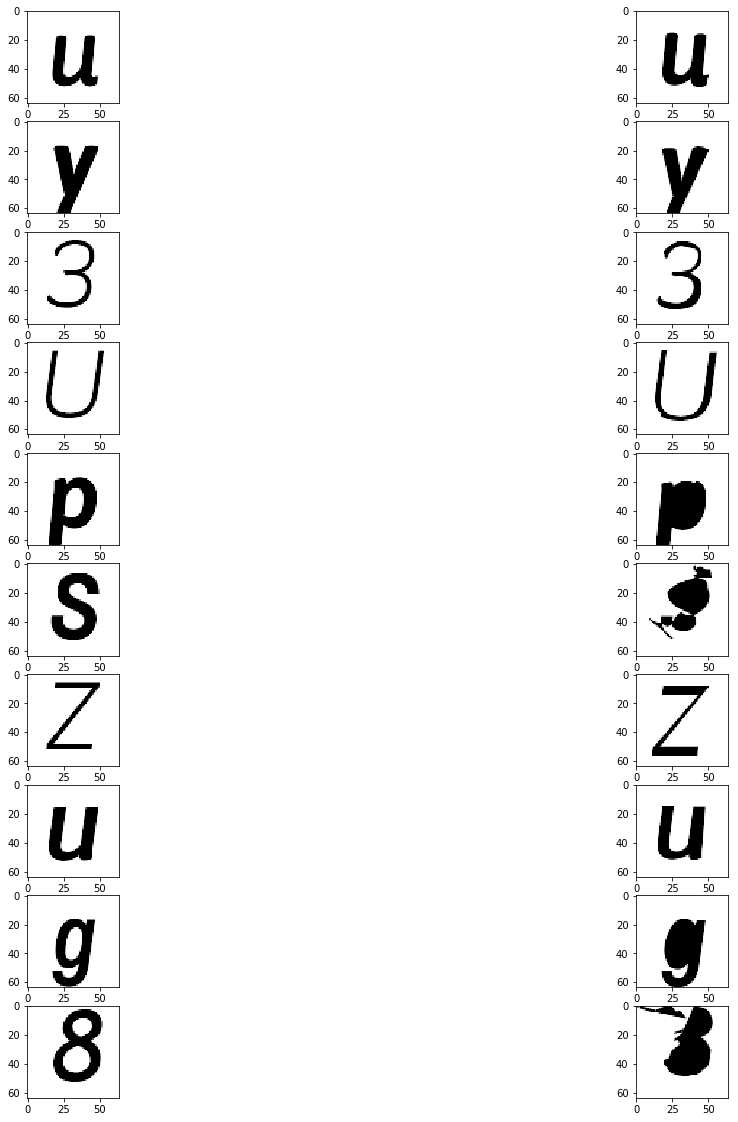

In [104]:
fig,axes = plt.subplots(10,2,figsize=(20,20))
for i in range(10):
    rp = path_from_tensors(y[0],y[1],i)
    rp = render_path_wand(rp,500,500)
    axes[i][0].imshow(rp)
    p = get_pred_path(x[[i]],labels[[i]],mean=True)
    ie = p.find("END")
    if ie is not None:
        p = p[:ie-1]
    else:
        p = p[:p.find("z")+1]

    #p = p[:len(rp)]
    img = render_path_wand(p,500,500)
    axes[i][1].imshow(img)

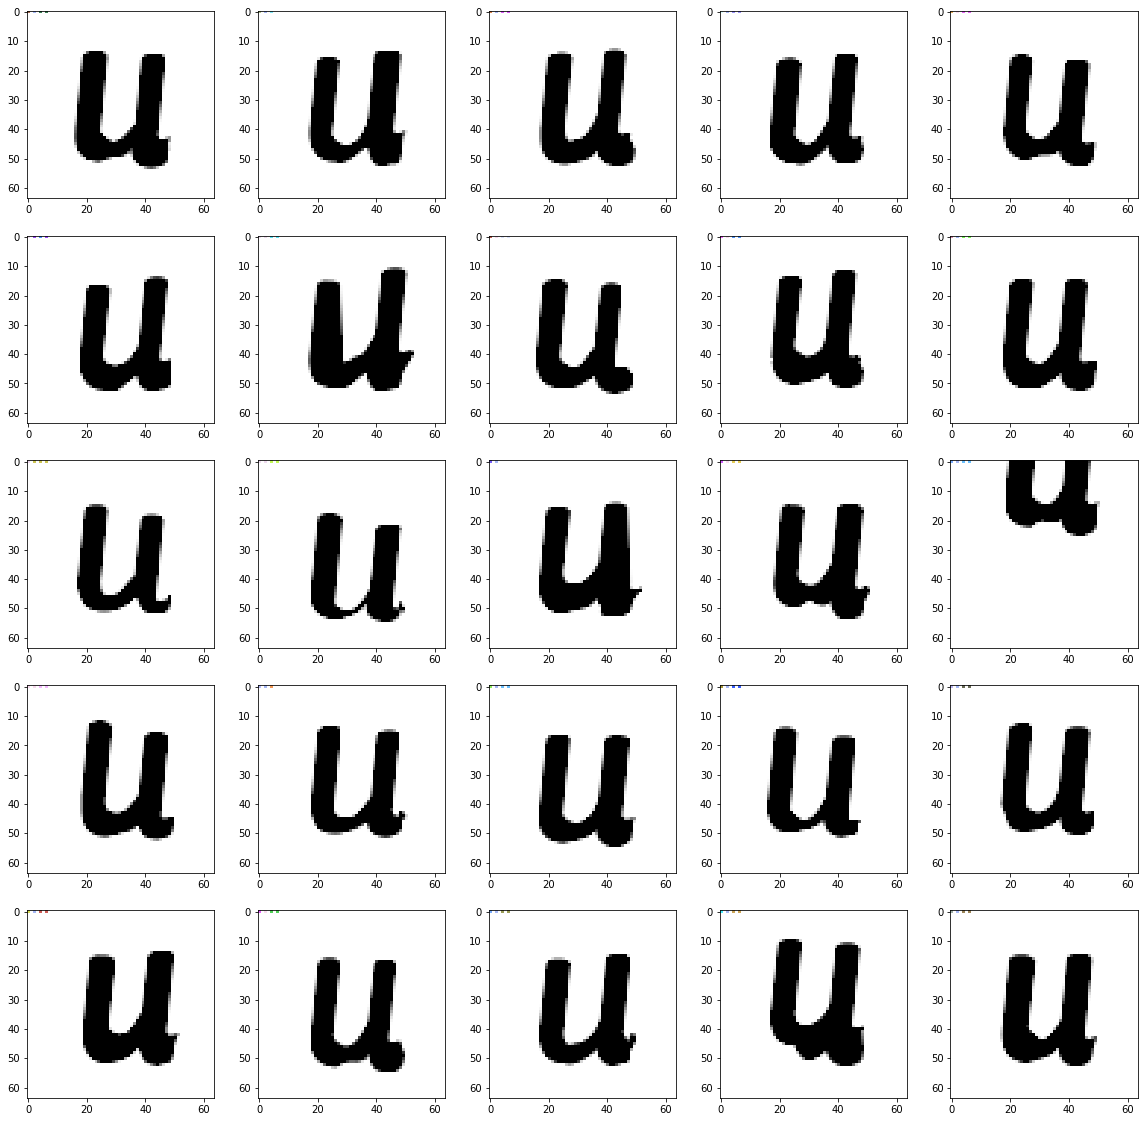

In [105]:
fig,axes = plt.subplots(5,5,figsize=(20,20))
i = 0
for ax in axes.flatten():
    p = get_pred_path(x[[i]],labels[[i]],mean=False)
    p = p[:p.find("END")-1]
    img = render_path_wand(p,500,500)
    ax.imshow(img)

In [44]:
class Agent(nn.Module):
    def __init__(self,num_tools,encoder_sd=None,tool_emb_sd=None):
        super().__init__()
        self.cnn = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        if encoder_sd is not None: self.cnn.load_state_dict(encoder_sd)
        self.cnn = self.cnn[:-2]
        #requires_grad(self.cnn,False)
        
        self.flatten = nn.Sequential(AdaptiveConcatPool2d(1),Flatten())
        self.tool_emb = nn.Embedding(num_tools,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        requires_grad(self.tool_emb,False)
        self.sv_to_hs = nn.Linear(128,1024)
        #self.path_encoder = nn.LSTM(128+4+4,1024,2,batch_first=True)
        self.path_encoder = AWD_LSTM(62,128+128+4+4,1024,3,0,input_p=0.0)
        self.tool_sel = nn.Linear(1024,1)
        self.num_tools = num_tools
#         self.adjust_mean = nn.Linear(128,num_tools*4)
#         self.adjust_std = nn.Linear(128,num_tools*4)
        self.adjust = MDN(1024,4,64,scale=0.03,use_sigmoid=True)
        self.template = torch.arange(0,201).unsqueeze(0).expand(64,-1).cuda()
        
        
    def get_log_probs(self, state, target, tools, pens, pens_comp, action, npen, real_pens, seq_mask=None):
        sv = self.flatten(self.cnn(state))
        tv = self.flatten(self.cnn(target))
        u = torch.cat([tv.unsqueeze(1).expand(-1,tools.shape[1],-1),sv.unsqueeze(1).expand(-1,tools.shape[1],-1),self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(tv).unsqueeze(0).expand(3,-1,-1).contiguous()
        output,_ = self.path_encoder(u,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        actions = torch.softmax(self.tool_sel(output).squeeze(-1),dim=1)
        adjust = self.adjust(output)
        #mean = 0.1*torch.tanh(self.adjust_mean(output).view(tools.shape[0],-1,self.num_tools,4))
        #std = 0.1*torch.sigmoid(self.adjust_std(output).view(tools.shape[0],-1,self.num_tools,4))
        mask = (tools != 0) & (tools != 8) & (tools != 9) & (tools != 6)
        first_end = torch.argmax(tools==9,dim=1,keepdim=True)
        self.template = torch.arange(0,tools.shape[1]).unsqueeze(0).expand(tools.shape[0],-1).cuda()
        mask = mask & (self.template < first_end)
        if seq_mask is not None: mask = mask & seq_mask
        actions = torch.where(mask,actions,torch.zeros_like(actions))
        actions = actions / actions.sum(dim=1,keepdim=True)

        dist_action = torch.distributions.Categorical(actions)
        action_log_probs = dist_action.log_prob(action)
        t = tools[torch.arange(tools.shape[0]),action]
        delta = torch.zeros_like(pens)
        adjust = [p[torch.arange(p.shape[0]),action] for p in adjust]

        #sigma = torch.clamp_max(adjust[1],0.05)
        sigma = 0.2*adjust[1]
        normals_dist = torch.distributions.Normal(adjust[2],sigma)
        pen_probs = torch.exp(normals_dist.log_prob(npen.unsqueeze(-1)))
        pen_probs = (adjust[0]*pen_probs).sum(dim=2)
        pen_log_probs = torch.log(pen_probs+1e-8)
        
        pens_comp = pens_comp[torch.arange(pens_comp.shape[0]),action]
        
        real_diff = real_pens - pens_comp
        real_probs = torch.exp(normals_dist.log_prob(real_diff.unsqueeze(-1)))
        real_probs = (adjust[0]*real_probs).sum(dim=2)
        real_log_probs = torch.log(real_probs+1e-8)
        
        return action_log_probs, pen_log_probs, real_log_probs
               
        
    def forward(self, state, target, tools, pens, explore=True, seq_mask=None, sigma_mult=1.0):
        sv = self.flatten(self.cnn(state))
        tv = self.flatten(self.cnn(target))
        u = torch.cat([tv.unsqueeze(1).expand(-1,tools.shape[1],-1),sv.unsqueeze(1).expand(-1,tools.shape[1],-1),self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(tv).unsqueeze(0).expand(3,-1,-1).contiguous()
        output,_ = self.path_encoder(u,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        actions = torch.softmax(self.tool_sel(output).squeeze(-1),dim=1)
        adjust = self.adjust(output)
        #mean = 0.1*torch.tanh(self.adjust_mean(output).view(tools.shape[0],-1,self.num_tools,4))
        #std = 0.1*torch.sigmoid(self.adjust_std(output).view(tools.shape[0],-1,self.num_tools,4))
        mask = (tools != 0) & (tools != 8) & (tools != 9) & (tools != 6)
        first_end = torch.argmax(tools==9,dim=1,keepdim=True)
        self.template = torch.arange(0,tools.shape[1]).unsqueeze(0).expand(64,-1).cuda()
        mask = mask & (self.template < first_end)
        if seq_mask is not None: mask = mask & seq_mask
        actions = torch.where(mask,actions,torch.zeros_like(actions))
        actions = actions / actions.sum(dim=1,keepdim=True)

        if torch.isnan(actions).sum() > 0:
            return
        #action_probs,action = torch.max(actions,dim=1)
        dist_action = torch.distributions.Categorical(actions)
        action = dist_action.sample()
        action_log_probs = dist_action.log_prob(action)
        action_entropy = dist_action.entropy()
        #action = torch.zeros_like(action).fill_(2)
        #print(action)
        #print(tools.shape,action.shape,action.max())
        t = tools[torch.arange(tools.shape[0]),action]
        #mean = mean[torch.arange(mean.shape[0]),action,t]
        #std = std[torch.arange(std.shape[0]),action,t]
        delta = torch.zeros_like(pens)
        adjust = [p[torch.arange(p.shape[0]),action] for p in adjust]
        
        pi_dist = torch.distributions.Categorical(adjust[0])
        s = pi_dist.sample()
        mu = torch.gather(adjust[2],2,s.unsqueeze(-1)).squeeze(-1)
        sigma = torch.gather(adjust[1],2,s.unsqueeze(-1)).squeeze(-1)
        
        if explore:
            sigma = 0.2*sigma
            sigma = torch.where(torch.rand_like(sigma) < 0.35,sigma,torch.zeros_like(sigma).fill_(0.015))
            dist = torch.distributions.Normal(mu,sigma)
            d = dist.sample()
            delta[torch.arange(tools.shape[0]),action] = d
            #print(f"am: {adjust[1].min()}")
            loss_dist = torch.distributions.Normal(adjust[2],adjust[1])
            l = torch.exp(loss_dist.log_prob(d.unsqueeze(-1)))
            l = torch.sum(l * adjust[0],dim=2)
            l = -torch.log(l+1e-8)
            if torch.isnan(l).sum() > 0:
                print("nan loss")
            return torch.clamp((pens + delta),-1.0,1.0), d, action_log_probs, l, action, action_entropy, loss_dist.entropy(), adjust[2], sigma
        else:
            d = torch.gather(adjust[2],2,torch.argmax(adjust[0],dim=2,keepdim=True)).squeeze(-1)
            delta[torch.arange(tools.shape[0]),action] = d
            return torch.clamp((pens + delta),-1.0,1.0), action

In [33]:
class Critic(nn.Module):
    def __init__(self,num_tools,encoder_sd=None,tool_emb_sd=None):
        super().__init__()
#         self.cnn = nn.Sequential(
#             conv2d(1,32,5,1,2),
#             nn.InstanceNorm2d(32,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(32,64,5,2,2),
#             nn.InstanceNorm2d(64,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(64,128,5,1,2),
#             nn.InstanceNorm2d(128,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(128,256,5,2,2),
#             nn.InstanceNorm2d(256,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(256,512,3,2,1))

        self.cnn = create_body(models.resnet34,pretrained=False)
        if encoder_sd is not None: self.cnn.load_state_dict(encoder_sd)
 
        self.flatten = nn.Sequential(AdaptiveConcatPool2d(1),Flatten())
        self.out = nn.Sequential(nn.Linear(512*2*2,256),nn.ReLU(inplace=True),nn.Linear(256,1))
        
    def forward(self, state, target, tools, pens, npens):
        sv = self.flatten(self.cnn(state.expand(-1,3,-1,-1)))
        tv = self.flatten(self.cnn(target.expand(-1,3,-1,-1)))
        u = torch.cat([sv,tv],dim=1)
        return self.out(u).squeeze(-1)

In [34]:
learnInit = Learner(dataAE,nn.Sequential(Lambda(lambda x: x.expand(-1,3,-1,-1)),create_body(models.resnet34,pretrained=True),create_head(512*2,dataAE.c)),metrics=accuracy)

In [39]:
learnInit.fit_one_cycle(10,3e-3)

In [40]:
torch.save(learnInit.model[1].state_dict(),"init-sd")

In [35]:
learnInit.model[1].load_state_dict(torch.load("init-sd"))

In [36]:
def tensors_to_path_string(tools,pens):
    paths = []
    for i in range(tools.shape[0]):
        out = []
        for t,p in zip(tools[i],pens[i]):
            t = data.vocab[t]
            out.append(t)
            out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
        path = " ".join(out)
        path = path[:path.find("END")-1]
        paths.append(path)
    return paths

In [37]:
def get_pred_paths(x,labels,mean=True):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
        
    paths = tensors_to_path_string(tools[:,1:-1],pens[:,1:-1])
    return paths,tools,pens

In [38]:
def render_path(path):
    return wand_to_tensor(render_path_wand(path,500,500))

def render_paths(paths):
    return torch.stack([render_path(p) for p in paths]).unsqueeze(1).cuda()

In [39]:
x,y = next(iter(data.train_dl))
target_paths = [path_from_tensors(y[0],y[1],i) for i in range(x.shape[0])]
targets = render_paths(target_paths)[[0]].expand(64,-1,-1,-1)
target_pens = y[1][[0]].expand(64,-1,-1)

# paths, tools, pens = get_pred_paths(x,y[2])
# start_state = render_paths(paths)[[0]].expand(64,-1,-1,-1)
# start_state_tools = tools[[0]].expand(64,-1)
# start_state_pens = pens[[0]].expand(64,-1,-1)

corrupted_pens = y[1] + torch.zeros_like(y[1]).normal_(0.0,0.015)
corrupted_pens[y[1]==-2.0] = -2.0
c_paths = [path_from_tensors(y[0],corrupted_pens,i) for i in range(x.shape[0])]
start_state = render_paths(c_paths)[[0]].expand(64,-1,-1,-1)
start_state_tools = y[0][[0]].expand(64,-1)
start_state_pens = corrupted_pens[[0]].expand(64,-1,-1)

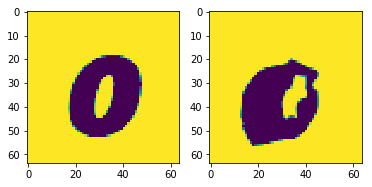

In [40]:
fig,axes = plt.subplots(1,2)
axes[0].imshow(targets[0,0])
axes[1].imshow(start_state[0,0])

In [41]:
def nparallel(func, arr:Collection, max_workers:int=None, leave=False):
    "Call `func` on every element of `arr` in parallel using `max_workers`."
    max_workers = ifnone(max_workers, defaults.cpus)
    if max_workers<2: results = [func(o,i) for i,o in progress_bar(enumerate(arr), total=len(arr), leave=leave)]
    else:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func,arr))
    return results

def set_lr(opt,lr):
    for pg in opt.param_groups:
        pg["lr"] = lr

Epoch 0: actor_real: -2.6172087687592414 actor_l: -0.1469314694404602 critic_l: 0.014264811761677265 reward: -0.043056368827819824 avg_reward: -0.00471328292042017 std_reward: 0.06300326436758041 avg_value: 0.08541838079690933 return: 0.17026981711387634 
mse: 1.0047132968902588 alp: 0.03335978463292122 deltas: 0.010374883189797401 mu: 0.0007173274643719196 sigma: 0.013409077189862728


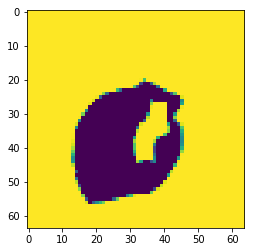

Epoch 1: actor_real: -2.3598510665103922 actor_l: 0.94245445728302 critic_l: 0.11216738075017929 reward: -0.03464794158935547 avg_reward: -0.008894260041415691 std_reward: 0.06600242108106613 avg_value: 1.2356672286987305 return: 0.9175108075141907 
mse: 1.0088942050933838 alp: 0.03349572420120239 deltas: 0.011574647389352322 mu: 0.0007164066191762686 sigma: 0.013442322611808777


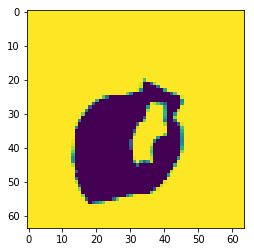

Epoch 2: actor_real: -2.573337820159108 actor_l: 0.10972598940134048 critic_l: 0.016550056636333466 reward: -0.006698966026306152 avg_reward: -0.0007646316662430763 std_reward: 0.061504557728767395 avg_value: 0.6167091131210327 return: 0.522273063659668 
mse: 1.0007646083831787 alp: 0.03340190276503563 deltas: 0.009583083912730217 mu: 0.0007158772787079215 sigma: 0.01321328803896904


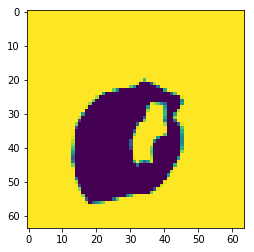

Epoch 3: actor_real: -2.462799789623883 actor_l: -0.24586349725723267 critic_l: 0.02837788686156273 reward: -0.031835079193115234 avg_reward: 0.004249521531164646 std_reward: 0.05879389867186546 avg_value: -0.03742378577589989 return: 0.09908561408519745 
mse: 0.9957504868507385 alp: 0.03332396596670151 deltas: 0.009717128239572048 mu: 0.0007157630752772093 sigma: 0.013343940488994122


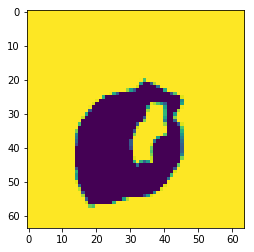

Epoch 4: actor_real: -2.4752603695631112 actor_l: -0.3557586967945099 critic_l: 0.05393737927079201 reward: 0.007146298885345459 avg_reward: -0.0016773389652371407 std_reward: 0.052786774933338165 avg_value: -0.2708074152469635 return: -0.06128494441509247 
mse: 1.0016772747039795 alp: 0.033339809626340866 deltas: 0.008710881695151329 mu: 0.0007169349119067192 sigma: 0.013227160088717937


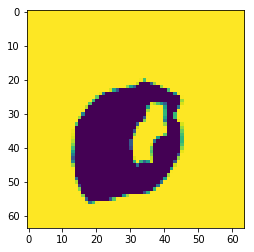

Epoch 5: actor_real: -2.5819261938994145 actor_l: -0.3038341701030731 critic_l: 0.04391755163669586 reward: -0.08738505840301514 avg_reward: 0.01207878440618515 std_reward: 0.06762378662824631 avg_value: -0.1573842167854309 return: 0.021552924066781998 
mse: 0.9879212379455566 alp: 0.03334929794073105 deltas: 0.01020141877233982 mu: 0.0007177309598773718 sigma: 0.013181124813854694


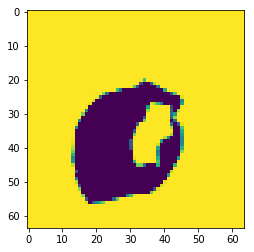

Epoch 6: actor_real: -2.405714576531796 actor_l: -0.059736840426921844 critic_l: 0.01086043007671833 reward: -0.06764602661132812 avg_reward: -0.0026499778032302856 std_reward: 0.06112492457032204 avg_value: 0.13431885838508606 return: 0.18725407123565674 
mse: 1.0026500225067139 alp: 0.03331010043621063 deltas: 0.01101638749241829 mu: 0.000719623058103025 sigma: 0.013201567344367504


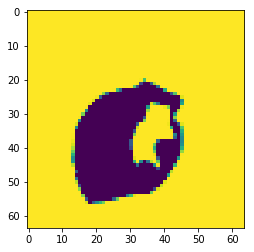

Epoch 7: actor_real: -2.5047400455924382 actor_l: 0.07489476352930069 critic_l: 0.013003715313971043 reward: -0.19962811470031738 avg_reward: -0.0017004748806357384 std_reward: 0.07296709716320038 avg_value: 0.44304025173187256 return: 0.3888716697692871 
mse: 1.001700520515442 alp: 0.03331403434276581 deltas: 0.010846194811165333 mu: 0.0007222895510494709 sigma: 0.01329135987907648


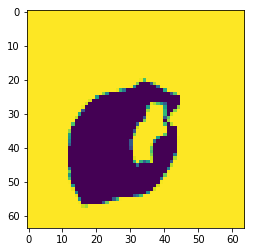

Epoch 8: actor_real: -2.8073408887066873 actor_l: 0.1461872011423111 critic_l: 0.03174126148223877 reward: 0.078072190284729 avg_reward: -0.002636939287185669 std_reward: 0.08378474414348602 avg_value: 0.6527963876724243 return: 0.5116915106773376 
mse: 1.0026369094848633 alp: 0.03352390602231026 deltas: 0.010806264355778694 mu: 0.0007241256535053253 sigma: 0.013296810910105705


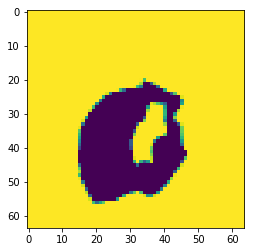

Epoch 9: actor_real: -2.5850372202815737 actor_l: 0.14763325452804565 critic_l: 0.03016253374516964 reward: -0.07838022708892822 avg_reward: -0.00019981898367404938 std_reward: 0.05296169966459274 avg_value: 0.6877896189689636 return: 0.5395731925964355 
mse: 1.000199794769287 alp: 0.03326447308063507 deltas: 0.01035862136632204 mu: 0.0007227403111755848 sigma: 0.01312793605029583


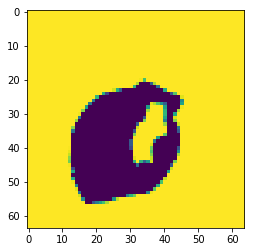

Epoch 10: actor_real: -2.6306151404261526 actor_l: 0.09942861646413803 critic_l: 0.021399036049842834 reward: 0.014521181583404541 avg_reward: -0.009139005094766617 std_reward: 0.06247509643435478 avg_value: 0.5762897729873657 return: 0.4556681215763092 
mse: 1.009139060974121 alp: 0.033285826444625854 deltas: 0.009412286803126335 mu: 0.0007235367665998638 sigma: 0.013209769502282143


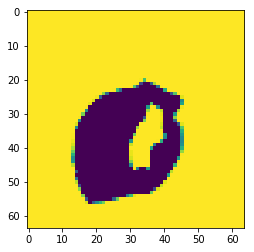

Epoch 11: actor_real: -2.675809429904715 actor_l: 0.01066618412733078 critic_l: 0.01079888641834259 reward: 0.036536455154418945 avg_reward: -0.00606283824890852 std_reward: 0.06069998815655708 avg_value: 0.3683108389377594 return: 0.3231310248374939 
mse: 1.0060628652572632 alp: 0.0333637073636055 deltas: 0.010543248616158962 mu: 0.0007244860753417015 sigma: 0.01337914913892746


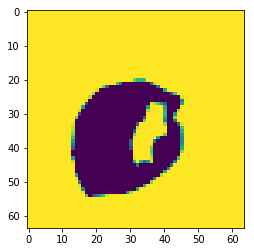

Epoch 12: actor_real: -2.597428237916062 actor_l: -0.06562298536300659 critic_l: 0.012156686745584011 reward: -0.06693041324615479 avg_reward: -0.0038568098098039627 std_reward: 0.06770849227905273 avg_value: 0.1416127234697342 return: 0.18213853240013123 
mse: 1.0038567781448364 alp: 0.03342611715197563 deltas: 0.011417358182370663 mu: 0.0007254455704241991 sigma: 0.01373613253235817


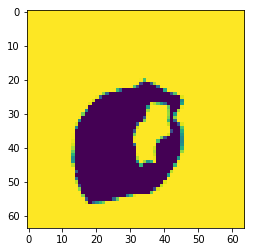

Epoch 13: actor_real: -2.5580303660735044 actor_l: -0.16002801060676575 critic_l: 0.019566385075449944 reward: 0.23704928159713745 avg_reward: 0.0016494961455464363 std_reward: 0.05830767750740051 avg_value: -0.024380650371313095 return: 0.07089780271053314 
mse: 0.9983505010604858 alp: 0.03337600827217102 deltas: 0.010081158950924873 mu: 0.000725561985746026 sigma: 0.013261864893138409


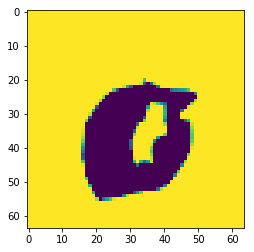

Epoch 14: actor_real: -2.5546418340173402 actor_l: -0.1839921623468399 critic_l: 0.014849448576569557 reward: -0.07293355464935303 avg_reward: -0.021027658134698868 std_reward: 0.05475225672125816 avg_value: -0.08565828204154968 return: -0.005403107963502407 
mse: 1.021027684211731 alp: 0.03296484053134918 deltas: 0.010444768704473972 mu: 0.0007278527482412755 sigma: 0.01326180063188076


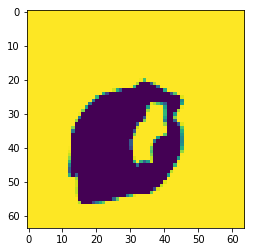

Epoch 15: actor_real: -2.6146249467917597 actor_l: -0.1998116672039032 critic_l: 0.022854389622807503 reward: 0.0 avg_reward: -0.00329462718218565 std_reward: 0.06285400688648224 avg_value: -0.06803935766220093 return: 0.04653439670801163 
mse: 1.0032947063446045 alp: 0.03378114849328995 deltas: 0.010363816283643246 mu: 0.0007314216927625239 sigma: 0.013086955063045025


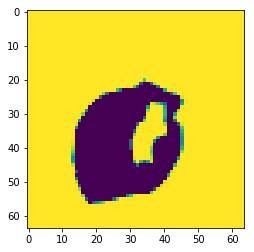

Epoch 16: actor_real: -2.556749338551656 actor_l: -0.05986528471112251 critic_l: 0.012079772539436817 reward: -0.16324090957641602 avg_reward: -0.008668927475810051 std_reward: 0.07106892019510269 avg_value: 0.047579117119312286 return: 0.10571493953466415 
mse: 1.0086688995361328 alp: 0.034041017293930054 deltas: 0.009987743571400642 mu: 0.0007364904740825295 sigma: 0.01333901472389698


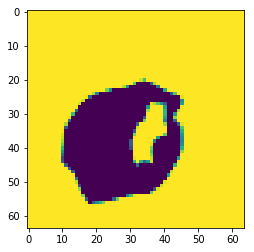

Epoch 17: actor_real: -2.5585404200458552 actor_l: -0.11587584018707275 critic_l: 0.012841529212892056 reward: 0.03834545612335205 avg_reward: 0.005744734779000282 std_reward: 0.06642432510852814 avg_value: 0.20270031690597534 return: 0.2319934070110321 
mse: 0.9942551851272583 alp: 0.034461840987205505 deltas: 0.011068882420659065 mu: 0.0007403880590572953 sigma: 0.013361937366425991


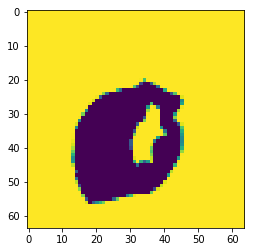

Epoch 18: actor_real: -2.6256723006857876 actor_l: 0.04578451067209244 critic_l: 0.011523854918777943 reward: 0.1675545573234558 avg_reward: -0.0018461374565958977 std_reward: 0.060226596891880035 avg_value: 0.36886656284332275 return: 0.3226802349090576 
mse: 1.0018460750579834 alp: 0.03370816260576248 deltas: 0.009724974632263184 mu: 0.0007569931913167238 sigma: 0.013205857947468758


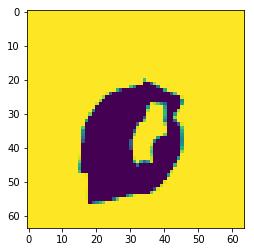

Epoch 19: actor_real: -2.6676378351038843 actor_l: 0.07448231428861618 critic_l: 0.016748830676078796 reward: -0.023714780807495117 avg_reward: 0.015040657483041286 std_reward: 0.07678725570440292 avg_value: 0.4778333604335785 return: 0.40791451930999756 
mse: 0.9849593639373779 alp: 0.04044152796268463 deltas: 0.010749836452305317 mu: 0.0007908530533313751 sigma: 0.013096621260046959


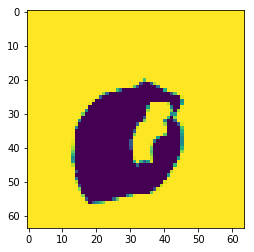

KeyboardInterrupt: 

In [51]:
agent = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
opt_agent = torch.optim.Adam(agent.parameters(),lr=1e-5)#,weight_decay=0.01)
#agent_copy = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
#agent_copy.load_state_dict(agent.state_dict())
#requires_grad(agent_copy,False)
critic = Critic(len(data.vocab),learnInit.model[1].state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
#critic_copy = Critic(len(data.vocab),learnInit.model[1].state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
#critic_copy.load_state_dict(critic.state_dict())
#requires_grad(critic_copy,False)
opt_critic = torch.optim.Adam(critic.parameters(),lr=1e-4,weight_decay=0.01)
action_mask = [torch.ByteTensor([1]*len(tool_dict[data.vocab[i]]) + [0]*(4-len(tool_dict[data.vocab[i]]))) for i in range(len(data.vocab))]
action_mask = torch.stack(action_mask).cuda()
sigma_mult = 1
feature_encoder = nn.Sequential(
    conv2d(1,32,5,1,2),
    nn.InstanceNorm2d(32,affine=True),
    nn.ReLU(),
    conv2d(32,32,5,2,2),
    nn.InstanceNorm2d(32,affine=True),
    nn.ReLU(),
    conv2d(32,64,5,1,2),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,5,2,2),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,3,2,1),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,3,2,1),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU()).cuda()
feature_encoder.load_state_dict(learnAE.model.encoder.state_dict())
feature_encoder = feature_encoder[:-2]
requires_grad(feature_encoder,False)

best_avg_reward = -1e10
agent_sd,agent_opt_sd,critic_sd,critic_opt_sd = None,None,None,None

with torch.autograd.detect_anomaly():
    return_store = []
    for epoch in range(150):
        state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
        state_history = [state.cpu()]
        state_pen_history = [state_pens]
        action_log_probs, pen_log_probs, rewards, actions, mses, entropy_a, entropy_p, values, deltas, mus, sigmas = [], [], [], [], [], [], [], [], [], [], []
        #target_features = feature_encoder(targets).detach()
        baseline_mse = F.l1_loss(start_state,targets,reduction="none").view(start_state.shape[0],-1).mean(dim=1) #+ 0.05*F.mse_loss(feature_encoder(start_state),target_features,reduction="none").view(start_state.shape[0],-1).mean(dim=1)
        baseline = torch.ones_like(baseline_mse)
        max_return = baseline.max()
        seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
        mask_history = [seq_mask.clone()]
        agent.eval()
        critic.train()
        for t in range(1):
            npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu, sigma = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=sigma_mult)
            v = critic(state,targets,state_tools,state_pens,npens)
            #v = torch.clamp_max(v,max_return)
            seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
            mask_history.append(seq_mask.clone())
            #print(state_pens-npens)
            state_pens = npens.detach()
            state_pen_history.append(state_pens)
            #print(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            #state = nparallel(render_paths(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            state = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))).unsqueeze(1).cuda()
            state_history.append(state.detach().cpu())
            mse = F.l1_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1) #+ 0.05*F.mse_loss(feature_encoder(state),target_features,reduction="none").view(state.shape[0],-1).mean(dim=1)
            mse = mse / baseline_mse
            reward = baseline - mse
            baseline = mse
            action_log_probs.append(action_probs.detach())
            pen_log_probs.append(pen_probs.detach())
            rewards.append(reward.detach())
            actions.append(action.detach())
            mses.append(mse.detach())
            entropy_a.append(action_entropy.detach())
            entropy_p.append(pen_entropy.detach())
            deltas.append(delta.detach())
            values.append(v)
            mus.append(mu.detach())
            sigmas.append(sigma.detach())
    
        action_log_probs = torch.stack(action_log_probs,dim=1)
        pen_log_probs = torch.stack(pen_log_probs,dim=1)
        rewards = torch.stack(rewards,dim=1)
        actions = torch.stack(actions,dim=1)
        mses = torch.stack(mses,dim=1)
        entropy_a = torch.stack(entropy_a,dim=1)
        entropy_p = torch.stack(entropy_p,dim=1)
        values = torch.stack(values,dim=1)
        deltas = torch.stack(deltas,dim=1)
        mus = torch.stack(mus,dim=1)
        sigmas = torch.stack(sigmas,dim=1)
        state_history = torch.stack(state_history,dim=1)[:,:-1]
        state_pen_history = torch.stack(state_pen_history,dim=1)[:,:-1]
        mask_history = torch.stack(mask_history,dim=1)[:,:-1]
        tool = torch.gather(state_tools,1,actions)
        
        avg_rewards = rewards.sum(dim=1).mean().item()
        if avg_rewards >= best_avg_reward:
            best_avg_reward = avg_rewards
            torch.save(agent.state_dict(),"agent.pth")
            torch.save(critic.state_dict(),"critic.pth")

            
        npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu, sigma = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=sigma_mult)
        v = critic(state,targets,state_tools,state_pens,npens)
        #v = torch.clamp_max(v,max_return)
        
        R = v
        next_value = v.detach()
        advantage = torch.zeros_like(v)
        #R = torch.zeros_like(v)
        returns = []
        advantages = []
        for i in reversed(range(rewards.shape[1])):
            R = rewards[:,i] + 0.95 * R
            returns.insert(0,R)
            d = rewards[:,i] + 0.95*next_value - values[:,i]
            next_value = values[:,i].detach()
            advantage = advantage*0.95*0.5 + d
            advantages.insert(0,advantage)
        returns = torch.stack(returns,dim=1).detach()    
        advantages = torch.stack(advantages,dim=1)
                
        #advantages = returns - values
        loss_critic = advantages.pow(2).mean() #+ 0.1*values.pow(2).mean()
        #set_lr(opt_critic,max(2e-5,2e-4/(1+(10*(epoch/100.0)))))
        opt_critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()
        #nn.utils.clip_grad_norm_(critic.parameters(),0.01)
        
#         alpha = min(epoch/10,0.9)
#         for npa,opa in zip(critic_copy.parameters(),critic.parameters()):
#             npa.data.mul_(alpha).add_((1-alpha)*opa.data)
        
        advantages = advantages.detach()
        #advantages = (advantages - advantages.mean()) / advantages.std()
        def get_minibatch(t,size,idxs):
            t = t.contiguous().view(-1,*t.shape[2:])
            t = t[idxs][:size]
            return t
        
        #set_lr(opt_agent,max(1e-4,1e-3/(1+(10*(epoch/100.0)))))
        
        agent.train()
        eps = 0.1
        num_samples = actions.shape[0] * actions.shape[1]
        bs = num_samples//2
        smooth_actor = SmoothenValue(0.90)
        for j in range(10):
            idxs = torch.randperm(num_samples)
            mb_actions = get_minibatch(actions,bs,idxs)
            mb_deltas = get_minibatch(deltas,bs,idxs)
            mb_states = get_minibatch(state_history,bs,idxs).cuda()
            mb_pens = get_minibatch(state_pen_history,bs,idxs)
            mb_pens_comp = get_minibatch(state_pen_history[:,:,1:],bs,idxs)
            mb_old_pen_probs = get_minibatch(pen_log_probs,bs,idxs)
            mb_old_action_probs = get_minibatch(action_log_probs,bs,idxs)
            mb_advantages = get_minibatch(advantages,bs,idxs)
            mb_masks = get_minibatch(mask_history,bs,idxs)
            mb_targets = get_minibatch(targets.unsqueeze(1).expand(-1,actions.shape[1],-1,-1,-1),bs,idxs)
            mb_tools = get_minibatch(start_state_tools.unsqueeze(1).expand(-1,actions.shape[1],-1),bs,idxs)
            mb_tool = mb_tools[torch.arange(mb_tools.shape[0]),mb_actions]
            mb_real = get_minibatch(target_pens[:,1:].unsqueeze(1).expand(-1,actions.shape[1],-1,-1),bs,idxs)
            mb_real = mb_real[torch.arange(mb_real.shape[0]),mb_actions]
            #print(state_pen_history.view(-1,*state_pen_history.shape[2:])[:20],target_pens.unsqueeze(1).view(-1,*target_pens.shape[1:])[:20])
            #print(mb_pens_comp[torch.arange(mb_pens_comp.shape[0]),mb_actions],mb_real)
            #print(f"pen {(mb_pens_comp[torch.arange(mb_pens_comp.shape[0]),mb_actions] - mb_real).pow(2).mean().item()}")
            new_action_probs, new_pen_probs, real_pen_probs = agent.get_log_probs(mb_states.detach(), mb_targets.detach(), mb_tools.detach(), mb_pens.detach(), mb_pens_comp.detach(), mb_actions.detach(), mb_deltas.detach(), mb_real.detach(), mb_masks.detach())

            r_pen = torch.exp(new_pen_probs-mb_old_pen_probs.detach()) 
            loss = torch.where(mb_advantages.unsqueeze(-1) >= 0,torch.min(r_pen,torch.zeros_like(r_pen).fill_(1+eps)),torch.max(r_pen,torch.zeros_like(r_pen).fill_(1-eps))) * mb_advantages.unsqueeze(-1)
            #loss = torch.min((mb_advantages.unsqueeze(-1) * r_pen),mb_advantages.unsqueeze(-1) * torch.clamp(r_pen,1.0-eps,1.0+eps))
            loss[~action_mask[mb_tool]] = 0.0
            l_pos = loss[(mb_advantages.unsqueeze(-1).expand(-1,4)>0) & action_mask[mb_tool]].mean()
            l_neg = -loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]].mean()
            if(not torch.isnan(l_pos) and not torch.isnan(l_neg)):
                sf = l_pos / (l_neg+1e-7)
                sf /= 10
                loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]] *= sf
            loss = torch.clamp(loss,-1.0,3.0)
            #print(loss[(mb_advantages.unsqueeze(-1).expand(-1,4)>0) & action_mask[mb_tool]].mean().item(),loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]].mean().item())
            loss = -loss.mean()
            r_action = torch.exp(new_action_probs-mb_old_action_probs.detach())
            loss = loss + -torch.min((mb_advantages * r_action),mb_advantages * torch.clamp(r_action,1.0-eps,1.0+eps)).mean()
            lp = loss.item()
            loss_real = -real_pen_probs[mb_real!=-2.0].mean()
            #loss = loss + loss_real
            smooth_actor.add_value(loss_real.item())
            opt_agent.zero_grad()
            loss.backward()
            opt_agent.step()

        
        #agent_copy.load_state_dict(agent.state_dict())
            
#         opt_agent.zero_grad()
#         loss.backward()
#         rnn_grads,mdn_grads = [],[]
#         for p in agent.path_encoder.parameters():
#             if p.grad is not None: rnn_grads.append(p.grad.abs().mean().item())
#         for p in agent.adjust.parameters():
#             if p.grad is not None: mdn_grads.append(p.grad.abs().mean().item())
#         print(agent.tool_sel.weight.grad.abs().mean().item() if agent.tool_sel.weight.grad is not None else "",np.mean(rnn_grads),np.mean(mdn_grads))
#         opt_agent.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: actor_real: {smooth_actor.smooth} actor_l: {lp} critic_l: {loss_critic.item()} reward: {rewards[0].sum().item()} avg_reward: {rewards.sum(dim=1).mean().item()} std_reward: {rewards.sum(dim=1).std().item()} avg_value: {values[:,0].mean().item()} return: {returns[:,0].mean().item()} \nmse: {mses[:,-1].mean().item()} alp: {action_log_probs.exp().mean().item()} deltas: {deltas[action_mask[tool]].abs().mean().item()} mu: {mus.abs().mean().item()} sigma: {sigmas.mean().item()}")# {0.01*entropy_a.mean()},{entropy_p.mean()}")
            plt.imshow(state[0,0])
            plt.show()

In [43]:
# torch.save(agent.state_dict(),"agent.pth")
# torch.save(critic.state_dict(),"critic.pth")

In [64]:
agent.load_state_dict(torch.load("agent.pth"))

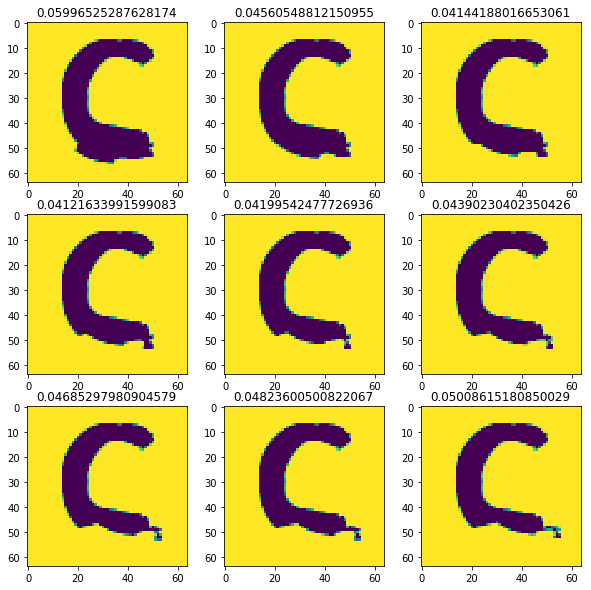

In [48]:
state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
agent.eval()
fig, axes = plt.subplots(3,3,figsize=(10,10))
axes[0,0].imshow(state[0,0])
axes[0,0].set_title(f"{F.mse_loss(state,targets).item()}")
with torch.no_grad():
    for t,ax in enumerate(axes.flatten()[1:]):
        npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mus = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=1)
        #npens, action = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=1,explore=False)
        seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
        state_pens = npens
        state = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))).unsqueeze(1).cuda()
        mse = F.mse_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1)
        best_mse = torch.argmax(-mse)
        state = state[[best_mse]].expand(64,-1,-1,-1)
        state_pens = state_pens[[best_mse]].expand(64,-1,-1)
        #ax.set_title(f"{F.mse_loss(state,targets).item()}")
        ax.set_title(f"{mse[best_mse]}")
        ax.imshow(state[0,0])

0.0007655286462977529 1.2924983768887918e-05 0.0003777239279768955
Epoch 0: 1.5739831924438477 2.4039342403411865 1.4901161193847656e-08 0.018389882519841194 0.0914267897605896 0.02395102009177208,-1.5775117874145508


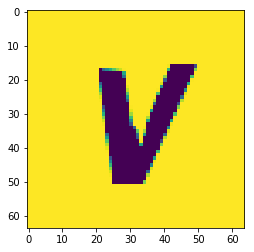

0.0009326579165644944 1.7194013262648394e-05 0.00037489978470972574
Epoch 1: 1.561108946800232 2.070552110671997 7.82310962677002e-08 0.020015019923448563 0.09142689406871796 0.023951232433319092,-1.5774612426757812


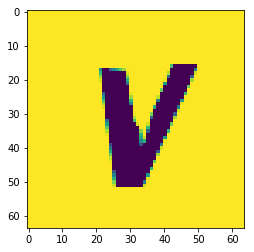

0.0006039472646079957 1.1025403490331579e-05 0.00037603016308425846
Epoch 2: 1.5781974792480469 1.879138708114624 7.450580596923828e-09 0.017964664846658707 0.09136654436588287 0.02395121566951275,-1.5772302150726318


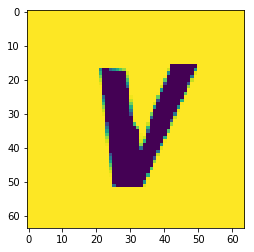

0.0010488081024959683 1.6846847382604817e-05 0.0003741710689427376
Epoch 3: 1.556400179862976 -1.3929425477981567 0.0 0.020292334258556366 0.09142100811004639 0.023951243609189987,-1.5771358013153076


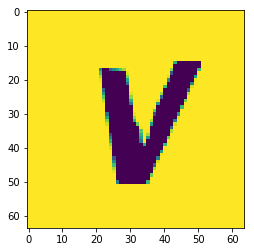

0.0004085150721948594 9.761140262298795e-06 0.00036842876510778666
Epoch 4: 1.5252052545547485 1.1384105682373047 1.4901161193847656e-08 0.017085842788219452 0.0915037989616394 0.023950936272740364,-1.5769259929656982


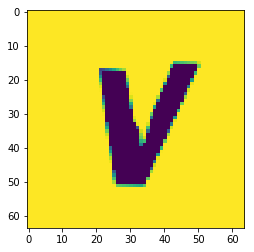

0.00048161915037781 1.0622512239895817e-05 0.0003767231536637716
Epoch 5: 1.5866397619247437 0.9410641193389893 6.705522537231445e-08 0.020083006471395493 0.09141425788402557 0.023951156064867973,-1.5767778158187866


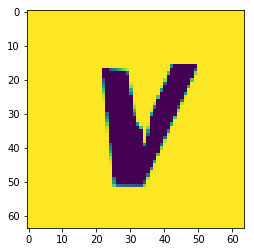

0.00048629799857735634 9.960291739237922e-06 0.000375014017416353
Epoch 6: 1.5709348917007446 0.9184969067573547 -7.450580596923828e-09 0.019257405772805214 0.0914444774389267 0.023951087146997452,-1.5766652822494507


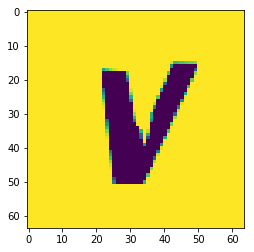

0.0003649643622338772 9.290185355818418e-06 0.00036978993450994163
Epoch 7: 1.5402048826217651 0.02615821361541748 4.470348358154297e-08 0.018773391842842102 0.09134145826101303 0.023950887843966484,-1.5765231847763062


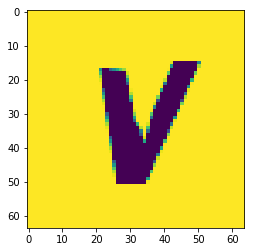

0.0008707435335963964 1.4366645568012851e-05 0.00037943517756981276
Epoch 8: 1.593172550201416 1.3749525547027588 0.0 0.018388399854302406 0.09141828864812851 0.023951029404997826,-1.5763511657714844


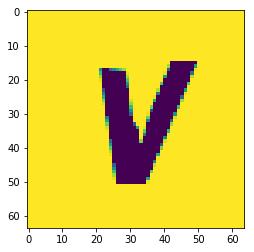

0.0006879209540784359 1.133736193992263e-05 0.0003805988965458103
Epoch 9: 1.602858304977417 1.1019940376281738 -1.4901161193847656e-08 0.01912587694823742 0.09150992333889008 0.023950647562742233,-1.5762107372283936


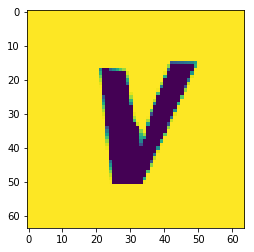

0.00043669913429766893 9.723004817866846e-06 0.0003766766654250316
Epoch 10: 1.5876693725585938 0.31071239709854126 -1.4901161193847656e-08 0.017661938443779945 0.09148506820201874 0.023951081559062004,-1.5760622024536133


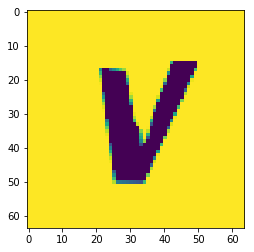

0.00038936847704462707 8.85360989855144e-06 0.00036779041721946015
Epoch 11: 1.5345131158828735 1.8910677433013916 -2.9802322387695312e-08 0.019292179495096207 0.09140323102474213 0.02395119145512581,-1.5759286880493164


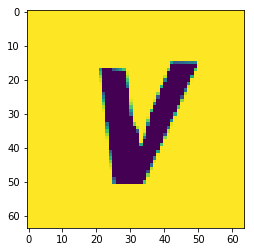

0.001021744916215539 1.629601260807097e-05 0.00037522267538843873
Epoch 12: 1.5813205242156982 0.48323962092399597 -5.960464477539063e-08 0.018888793885707855 0.09143664687871933 0.02395109087228775,-1.5758042335510254


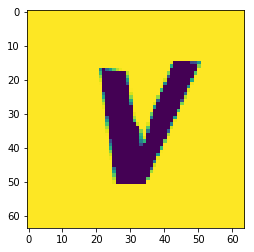

0.0006036236300133169 1.024126684493846e-05 0.000365239287522634
Epoch 13: 1.5218082666397095 1.0375059843063354 -5.21540641784668e-08 0.018759872764348984 0.09140165150165558 0.02395113743841648,-1.5756810903549194


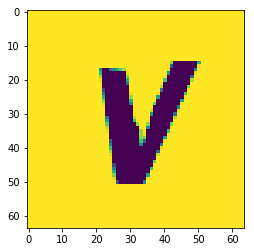

0.0004147301078774035 9.079561290074404e-06 0.00037063118085615504
Epoch 14: 1.5471470355987549 0.7391600012779236 0.0 0.0183428805321455 0.09139315783977509 0.02395097352564335,-1.5755376815795898


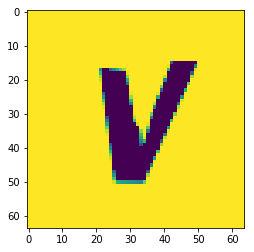

0.0003315091016702354 9.6396603055382e-06 0.0003728779158399161
Epoch 15: 1.5516663789749146 1.7136069536209106 -5.587935447692871e-08 0.017962437123060226 0.09150181710720062 0.023951105773448944,-1.575425148010254


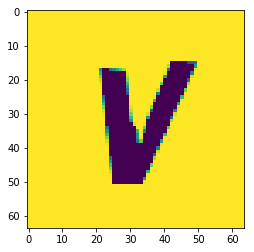

0.0005884903366677463 1.054373411572366e-05 0.0003715477510866094
Epoch 16: 1.5507041215896606 -1.9451879262924194 4.470348358154297e-08 0.017360668629407883 0.09147670120000839 0.023951184004545212,-1.5752171277999878


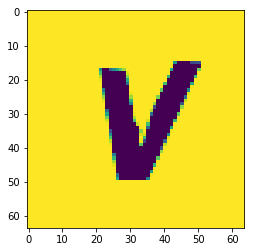

0.0008508397149853408 1.4755490582274433e-05 0.0003669771390468017
Epoch 17: 1.5282245874404907 0.4316696524620056 1.1175870895385742e-08 0.01913905330002308 0.09145413339138031 0.023951005190610886,-1.5751454830169678


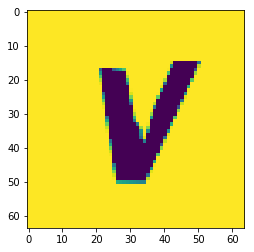

0.0002866482827812433 8.404746102049407e-06 0.00037440777307658674
Epoch 18: 1.5790526866912842 1.996781587600708 -7.450580596923828e-08 0.018293533474206924 0.09143200516700745 0.023951109498739243,-1.5749835968017578


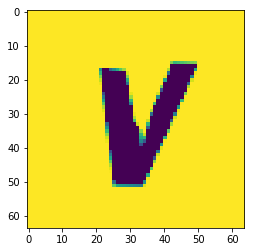

0.0005392531165853143 1.0092570680816001e-05 0.0003696671262200339
Epoch 19: 1.5456653833389282 1.6558709144592285 3.3527612686157227e-08 0.017963318154215813 0.09140841662883759 0.023951219394803047,-1.5748538970947266


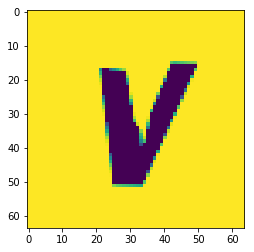

0.00044667714973911643 8.919230502613118e-06 0.00037129320293753193
Epoch 20: 1.5613256692886353 -0.30547499656677246 8.195638656616211e-08 0.018400507047772408 0.09143980592489243 0.023951129987835884,-1.5747636556625366


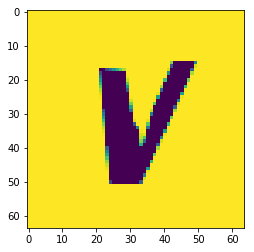

0.000546663417480886 1.0136792807221203e-05 0.00037255051631834846
Epoch 21: 1.5674761533737183 -2.1189165115356445 2.2351741790771484e-08 0.018715832382440567 0.09145301580429077 0.023950980976223946,-1.5745658874511719


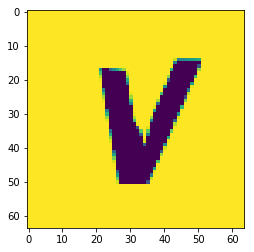

0.000570518895983696 9.861204193365817e-06 0.00037330573051737775
Epoch 22: 1.557784914970398 0.9924583435058594 -1.862645149230957e-08 0.01826183870434761 0.09137740731239319 0.023950980976223946,-1.574446439743042


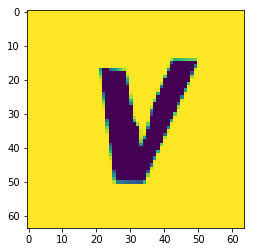

0.00035559647949412465 8.556852764722104e-06 0.00037959002530851826
Epoch 23: 1.603359580039978 -1.5301926136016846 7.450580596923828e-09 0.01894778572022915 0.09141482412815094 0.023950818926095963,-1.5743091106414795


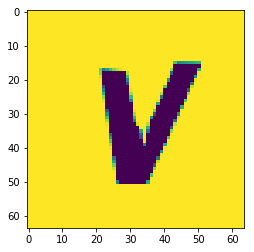

0.0005643945769406855 9.727412096556995e-06 0.0003695773441464804
Epoch 24: 1.5439081192016602 0.33431553840637207 2.2351741790771484e-08 0.01952330581843853 0.09142687171697617 0.023951184004545212,-1.5742535591125488


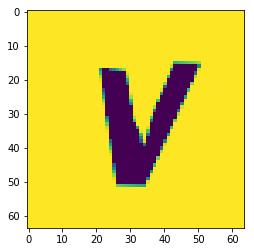

0.0005033951019868255 1.0861388564838611e-05 0.0003681977171409538
Epoch 25: 1.537068486213684 0.5411909222602844 -2.9802322387695312e-08 0.018443455919623375 0.09146171063184738 0.023951180279254913,-1.5740747451782227


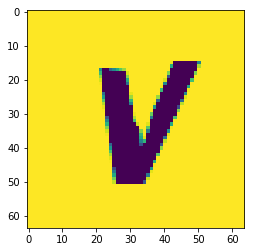

0.0006574810249730945 1.1866545520433647e-05 0.00037570807307870285
Epoch 26: 1.5780330896377563 0.7724370956420898 4.470348358154297e-08 0.018724653869867325 0.09135472774505615 0.023950990289449692,-1.5739296674728394


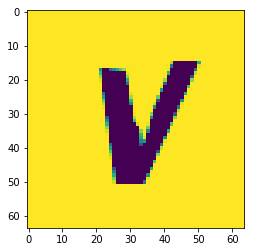

0.00042088303598575294 8.86066919984311e-06 0.0003700062067215996
Epoch 27: 1.55061936378479 -1.5120853185653687 2.9802322387695312e-08 0.01917196437716484 0.09143660962581635 0.023950627073645592,-1.573778510093689


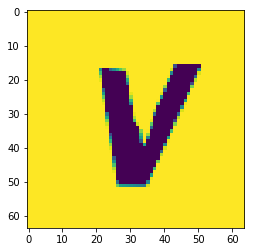

0.00037487279041670263 9.276476795605504e-06 0.0003694837176517751
Epoch 28: 1.5484273433685303 0.5742212533950806 3.725290298461914e-08 0.019655240699648857 0.09147932380437851 0.02395094558596611,-1.5736620426177979


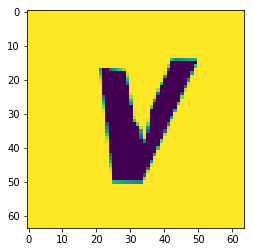

0.000479950598673895 9.24818162199396e-06 0.00037645971708003917
Epoch 29: 1.5748915672302246 2.1320037841796875 2.2351741790771484e-08 0.016562262549996376 0.09124588221311569 0.0239507257938385,-1.573547601699829


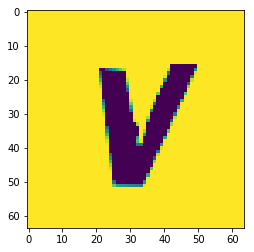

0.00036308279959484935 9.078182680847627e-06 0.00037460190466465093
Epoch 30: 1.5676467418670654 1.566877007484436 2.2351741790771484e-08 0.01793655753135681 0.09130861610174179 0.02395036444067955,-1.5734323263168335


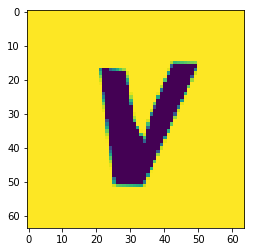

0.0004942354280501604 9.864752674578389e-06 0.0003719724384494416
Epoch 31: 1.550946831703186 0.6194518804550171 1.4901161193847656e-08 0.018924307078123093 0.09143271297216415 0.0239503663033247,-1.5732848644256592


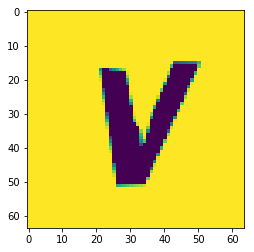

0.0003445904585532844 8.620129960945633e-06 0.00037190814408938344
Epoch 32: 1.5588306188583374 0.25724780559539795 -1.1175870895385742e-08 0.018342284485697746 0.09141162037849426 0.02395050972700119,-1.5731513500213623


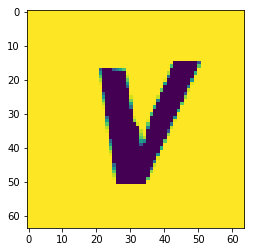

0.00022686079319100827 7.505151520111515e-06 0.00037494494888390406
Epoch 33: 1.581728219985962 -0.5730633735656738 7.450580596923828e-09 0.01885944791138172 0.09143425524234772 0.023950399830937386,-1.573014736175537


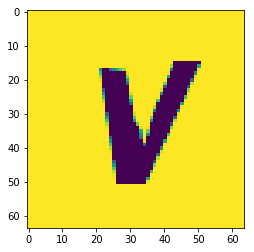

0.00033404334681108594 8.705404603404077e-06 0.0003762043404280657
Epoch 34: 1.5684750080108643 -1.6133760213851929 1.1175870895385742e-08 0.019002225250005722 0.09137323498725891 0.023950524628162384,-1.5728487968444824


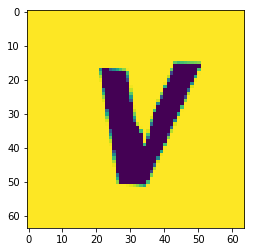

0.0005174188991077244 1.0057252450697737e-05 0.00037135747853334067
Epoch 35: 1.5462450981140137 -2.0334157943725586 2.60770320892334e-08 0.01871112547814846 0.09153378009796143 0.023950567469000816,-1.572695255279541


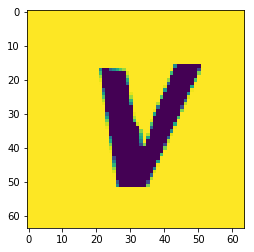

0.0004360843449831009 8.287559680297818e-06 0.00036802168355254405
Epoch 36: 1.531430721282959 -0.17070189118385315 -1.4901161193847656e-08 0.018501481041312218 0.09142667055130005 0.02395031601190567,-1.5725778341293335


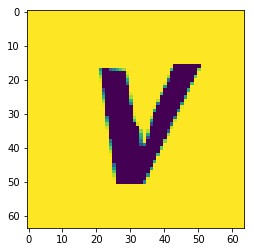

0.0004999451339244843 1.0820205252078571e-05 0.00037612319144786355
Epoch 37: 1.581923246383667 -0.04718303680419922 -1.4901161193847656e-08 0.01848045364022255 0.09143417328596115 0.023950451985001564,-1.5724185705184937


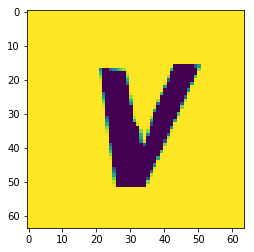

0.0002866222057491541 8.544485960252738e-06 0.0003790503857149889
Epoch 38: 1.5939096212387085 0.06297999620437622 -1.4901161193847656e-08 0.019989803433418274 0.09143047034740448 0.023950543254613876,-1.5722987651824951


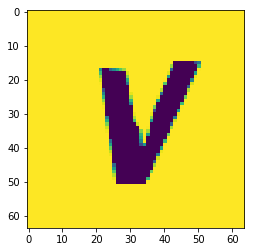

0.00038629959453828633 8.533639710132471e-06 0.0003748642380309401
Epoch 39: 1.54929780960083 -0.13380205631256104 -4.470348358154297e-08 0.0200739037245512 0.0913749560713768 0.0239506047219038,-1.5721696615219116


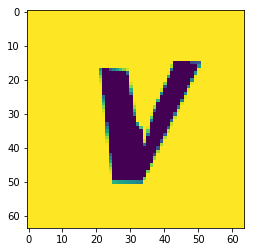

0.000334407901391387 8.442452210507176e-06 0.0003820751188406228
Epoch 40: 1.599822998046875 0.1428394466638565 0.0 0.019440624862909317 0.09128062427043915 0.02395058050751686,-1.5720057487487793


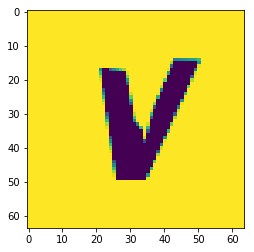

0.00045169374789111316 9.077495003377104e-06 0.00037754239900496717
Epoch 41: 1.5665167570114136 0.5461674928665161 1.4901161193847656e-08 0.018099868670105934 0.09142258763313293 0.023950450122356415,-1.5718806982040405


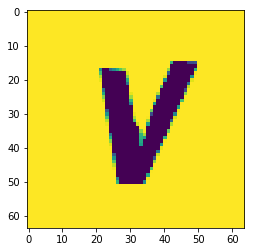

0.0005555139505304396 1.012211506197976e-05 0.00037877103835470827
Epoch 42: 1.5817601680755615 -0.5901409387588501 4.470348358154297e-08 0.01814926229417324 0.09141220897436142 0.023950209841132164,-1.571706771850586


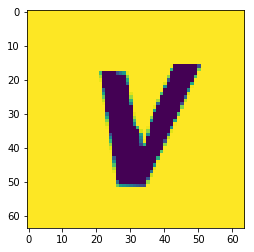

0.0007767287315800786 1.3729967614987496e-05 0.0003790039241514294
Epoch 43: 1.5738463401794434 0.012950539588928223 2.9802322387695312e-08 0.01918400079011917 0.09142172336578369 0.023950209841132164,-1.5716197490692139


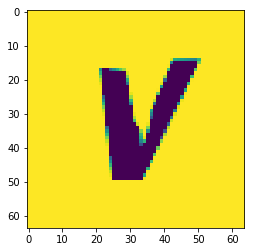

0.0006729266024194658 1.0998762398628514e-05 0.0003759165595556002
Epoch 44: 1.576522707939148 -1.419722318649292 7.450580596923828e-09 0.01842220313847065 0.09139000624418259 0.023950189352035522,-1.5714335441589355


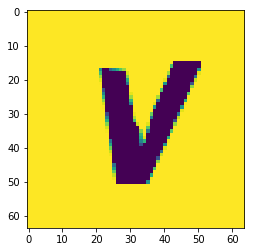

0.0005925212753936648 1.1442721787583801e-05 0.0003704546573414976
Epoch 45: 1.5362355709075928 -1.342843770980835 1.1920928955078125e-07 0.0194283165037632 0.09152381122112274 0.023949598893523216,-1.5712928771972656


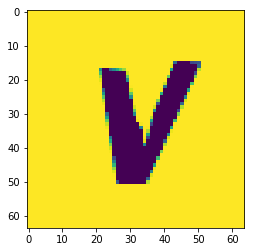

0.0003557904274202883 8.461902948416386e-06 0.0003706364671024846
Epoch 46: 1.540804386138916 -2.6078851222991943 1.4901161193847656e-08 0.01932075433433056 0.09154467284679413 0.023949861526489258,-1.571112036705017


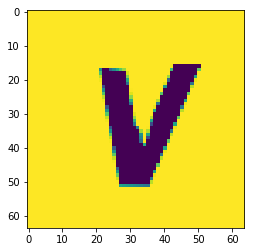

0.0007889112457633018 1.255102501337054e-05 0.0003758226634071882
Epoch 47: 1.5571941137313843 -0.4347555637359619 -2.2351741790771484e-08 0.02000799961388111 0.09145107120275497 0.023949848487973213,-1.5709636211395264


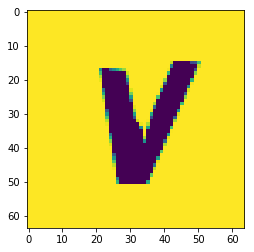

0.00048290210543200374 9.043372280359563e-06 0.0003666712034402497
Epoch 48: 1.5117557048797607 -3.9057998657226562 5.21540641784668e-08 0.01818658411502838 0.09131696075201035 0.02394927851855755,-1.5707995891571045


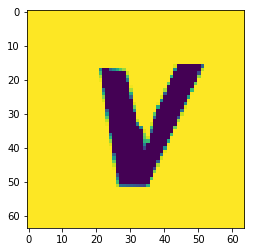

0.0002515163505449891 7.706441735422231e-06 0.00038101584627788415
Epoch 49: 1.5920428037643433 -3.4584245681762695 2.9802322387695312e-08 0.019034288823604584 0.09140288829803467 0.023949207738041878,-1.570658564567566


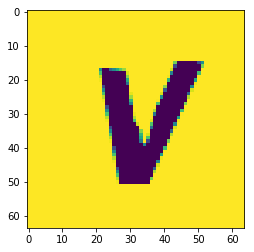

0.0003024580655619502 9.233772201374299e-06 0.0003747310332719393
Epoch 50: 1.5396755933761597 -3.261648178100586 4.470348358154297e-08 0.020226307213306427 0.09156307578086853 0.023949692025780678,-1.5704530477523804


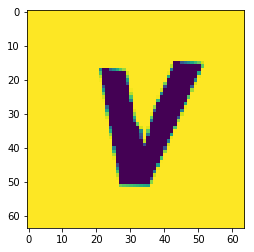

0.00020029059669468552 7.643798535165539e-06 0.00037283536744921647
Epoch 51: 1.5354814529418945 0.24410368502140045 -3.725290298461914e-08 0.017885547131299973 0.09146663546562195 0.02394888736307621,-1.5703370571136475


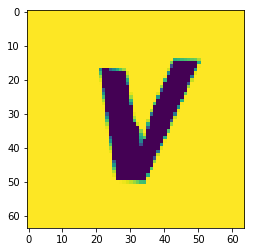

0.00028210890013724566 8.568323574801676e-06 0.00038152906014832233
Epoch 52: 1.5822359323501587 1.709949016571045 0.0 0.01938103884458542 0.0914318785071373 0.023949185386300087,-1.5701870918273926


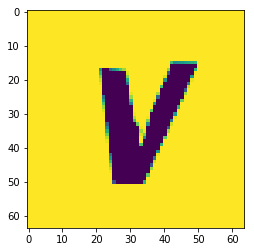

0.00046144978841766715 9.057928582005085e-06 0.00037664704840482494
Epoch 53: 1.561238408088684 1.9531776905059814 2.9802322387695312e-08 0.019048623740673065 0.09121166169643402 0.02394922450184822,-1.5700010061264038


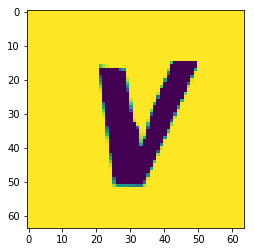

0.0002393134345766157 7.851906335787362e-06 0.0003800624078088936
Epoch 54: 1.5689458847045898 0.6184909343719482 2.9802322387695312e-08 0.018842477351427078 0.09155502170324326 0.023949140682816505,-1.5697702169418335


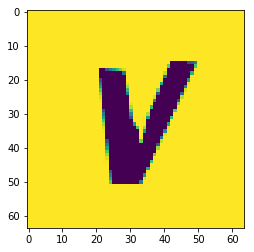

0.0003182940708938986 8.610205062116924e-06 0.0003839175265761459
Epoch 55: 1.590466856956482 -1.3576617240905762 3.725290298461914e-08 0.018561286851763725 0.09152626246213913 0.02394898422062397,-1.5696837902069092


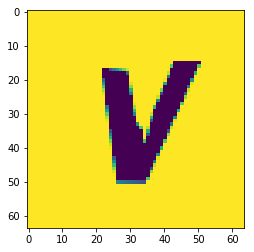

0.0002241573529317975 8.030994488687307e-06 0.0003796175956751006
Epoch 56: 1.5664454698562622 1.0402774810791016 1.4901161193847656e-08 0.017832225188612938 0.09139250218868256 0.023949431255459785,-1.5695257186889648


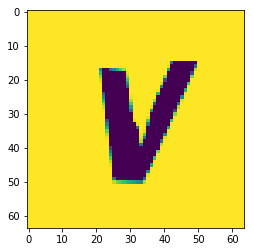

0.00025217252550646663 8.56177627639454e-06 0.00038058383765660064
Epoch 57: 1.5531476736068726 0.44525575637817383 -5.21540641784668e-08 0.018513206392526627 0.09125771373510361 0.02394901216030121,-1.5693063735961914


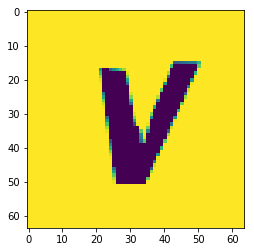

0.00019768040510825813 7.738347496418404e-06 0.00037584322590148805
Epoch 58: 1.537975549697876 0.7276041507720947 -1.862645149230957e-08 0.01818200573325157 0.09158362448215485 0.023949678987264633,-1.5691277980804443


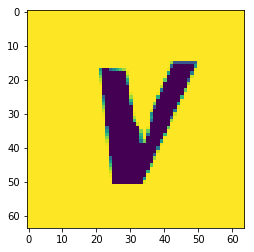

0.00032255559926852584 8.532447987856054e-06 0.00037928437719814134
Epoch 59: 1.5523303747177124 -1.8368730545043945 0.0 0.01789739355444908 0.09162409603595734 0.02394914999604225,-1.568901777267456


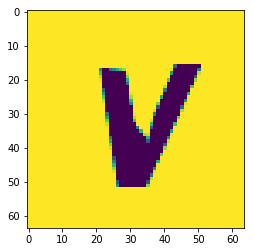

0.0004777978756465018 9.74614525735736e-06 0.00038257117042113836
Epoch 60: 1.5654945373535156 0.38480639457702637 0.0 0.018249912187457085 0.09122289717197418 0.023949259892106056,-1.568764090538025


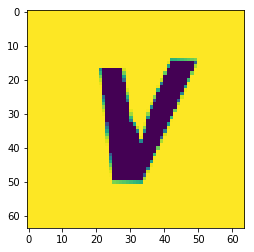

0.0004867149982601404 9.293010530579219e-06 0.0003876143223513114
Epoch 61: 1.589884877204895 -2.871781587600708 2.9802322387695312e-08 0.018676435574889183 0.09165439009666443 0.02394881844520569,-1.5685977935791016


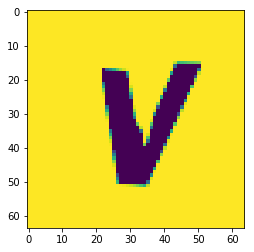

0.00017507791926618665 7.815608877118999e-06 0.00037813249702567386
Epoch 62: 1.5534989833831787 0.02835923433303833 1.4901161193847656e-08 0.020276932045817375 0.09146086871623993 0.02394949458539486,-1.568375587463379


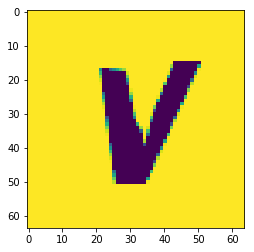

0.00036013187491334975 9.069321829239621e-06 0.0003823356722221967
Epoch 63: 1.5951374769210815 -0.356833815574646 7.450580596923828e-09 0.018233537673950195 0.09152011573314667 0.023949608206748962,-1.5681794881820679


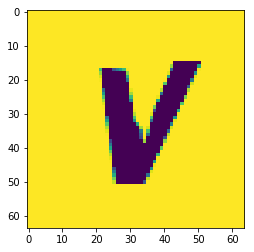

0.00017378971097059548 7.996434020422308e-06 0.00038179740389991207
Epoch 64: 1.567477822303772 -0.10984742641448975 2.9802322387695312e-08 0.01893450692296028 0.09133198112249374 0.023949632421135902,-1.5679943561553955


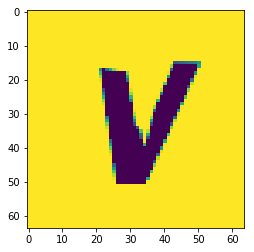

0.00030088951461948454 9.091272095436883e-06 0.0003849704343999634
Epoch 65: 1.5744706392288208 0.3552968204021454 2.9802322387695312e-08 0.018915362656116486 0.09155213087797165 0.023949474096298218,-1.5678441524505615


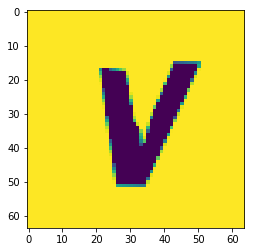

0.0006855432293377817 1.2262061019896464e-05 0.0003823582548041493
Epoch 66: 1.557108998298645 -2.1567113399505615 -7.450580596923828e-09 0.018737727776169777 0.09148150682449341 0.023949656635522842,-1.5675840377807617


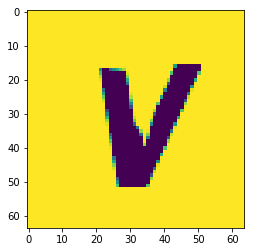

0.0002743506047409028 8.325016748263655e-06 0.0003774614618714163
Epoch 67: 1.5347651243209839 -0.07403188943862915 7.450580596923828e-08 0.019229402765631676 0.09143941104412079 0.023949913680553436,-1.5673778057098389


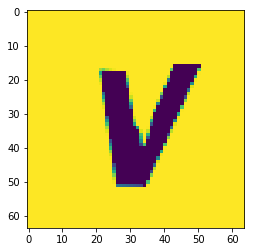

0.00017838997882790864 8.527085545514032e-06 0.00038892957846359266
Epoch 68: 1.5971906185150146 -0.20142579078674316 -1.1175870895385742e-08 0.018904130905866623 0.09154674410820007 0.0239496398717165,-1.5671954154968262


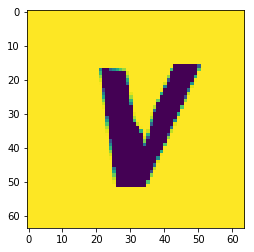

0.0005332703585736454 1.1010814821095968e-05 0.00038003754284628616
Epoch 69: 1.5407487154006958 0.09254777431488037 2.9802322387695312e-08 0.018931910395622253 0.0913313552737236 0.023949863389134407,-1.5670264959335327


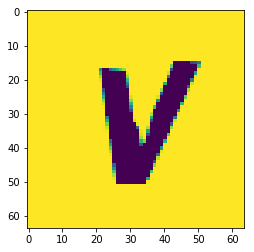

0.00036075239768251777 9.046292646530674e-06 0.0003790654930081831
Epoch 70: 1.533777117729187 -2.23095703125 3.725290298461914e-08 0.017919111996889114 0.09163486212491989 0.023949960246682167,-1.5668039321899414


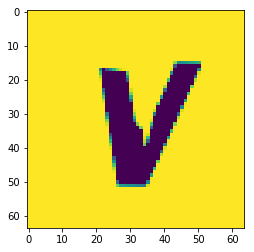

0.00018027963233180344 8.525775073782901e-06 0.0003859536571593954
Epoch 71: 1.574520468711853 0.31088805198669434 1.4901161193847656e-08 0.01959257945418358 0.09140782058238983 0.023949891328811646,-1.5665414333343506


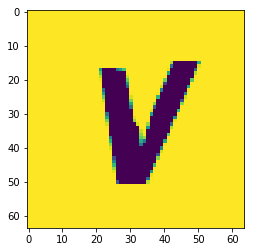

0.0001454615849070251 7.972360973459066e-06 0.0003751683619125738
Epoch 72: 1.5068359375 -1.2910369634628296 0.0 0.019042059779167175 0.09158311784267426 0.023949792608618736,-1.566327452659607


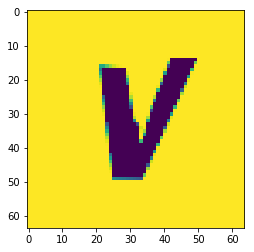

0.00048632657853886485 1.027403958649605e-05 0.0003825749539719814
Epoch 73: 1.5616270303726196 2.0288546085357666 1.862645149230957e-08 0.0199105367064476 0.09120281785726547 0.023949794471263885,-1.566124677658081


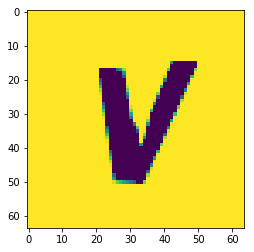

0.00018756912322714925 8.703968725617036e-06 0.00038935415369730403
Epoch 74: 1.576825737953186 -1.8368754386901855 -7.450580596923828e-09 0.0186002254486084 0.09167920053005219 0.023949673399329185,-1.5658735036849976


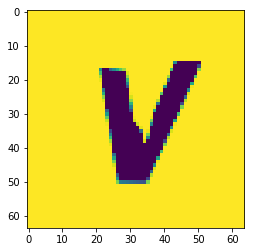

0.0001504236424807459 8.684640055397116e-06 0.00038538396074331666
Epoch 75: 1.5630742311477661 -2.2800486087799072 7.450580596923828e-08 0.01881289854645729 0.09142065048217773 0.023950133472681046,-1.5656393766403198


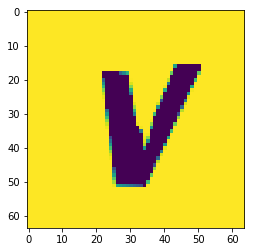

0.00023700219753663987 9.037613023584376e-06 0.0003793326463159552
Epoch 76: 1.5308936834335327 1.407119870185852 1.30385160446167e-08 0.01812971755862236 0.09155227243900299 0.023950280621647835,-1.5654000043869019


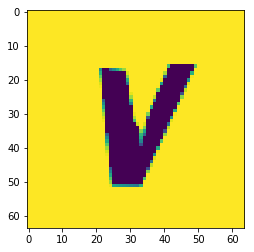

0.00044504881952889264 1.0915803670741298e-05 0.00038728941089383184
Epoch 77: 1.5696585178375244 0.7628931999206543 -7.450580596923828e-09 0.017550289630889893 0.09151880443096161 0.02394985407590866,-1.5651941299438477


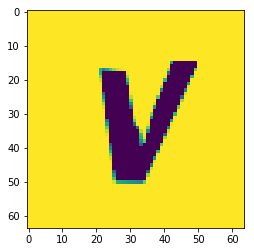

0.0003225567052140832 9.444013948941196e-06 0.0003808931881997453
Epoch 78: 1.5313273668289185 -1.718631625175476 5.960464477539063e-08 0.01889983005821705 0.09128563106060028 0.023950306698679924,-1.5649545192718506


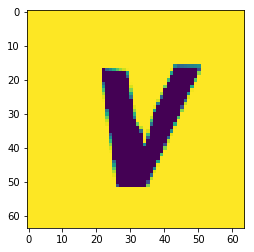

0.0003204624226782471 9.031530758818462e-06 0.0003771905546528324
Epoch 79: 1.4991557598114014 0.9655970335006714 1.1920928955078125e-07 0.019526513293385506 0.09152713418006897 0.02395028993487358,-1.5646841526031494


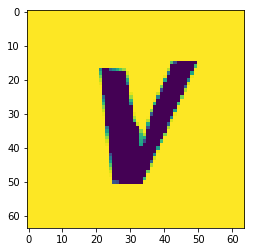

0.00026598863769322634 9.347691523942103e-06 0.00038632452794473693
Epoch 80: 1.5642439126968384 0.8736521601676941 -2.2351741790771484e-08 0.01754555106163025 0.09137128293514252 0.02395053580403328,-1.5644335746765137


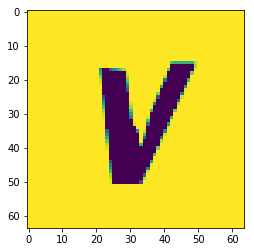

0.0004262271977495402 1.1118256137384227e-05 0.00039432334658240364
Epoch 81: 1.5958027839660645 0.5030153393745422 -6.705522537231445e-08 0.018987882882356644 0.09139382839202881 0.023950351402163506,-1.5641788244247437


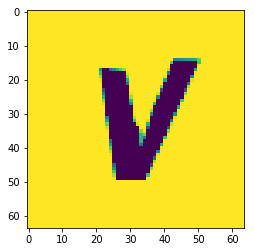

0.00041570860776118934 1.0722123524449975e-05 0.00038322192430732355
Epoch 82: 1.5240610837936401 -0.7769990563392639 5.960464477539063e-08 0.018881376832723618 0.09148404002189636 0.02395051345229149,-1.5638965368270874


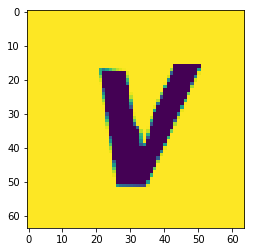

0.00023697706637904048 9.341414906790154e-06 0.00038428576737577674
Epoch 83: 1.547385334968567 1.399869680404663 1.4901161193847656e-08 0.018823379650712013 0.09130346029996872 0.02395043708384037,-1.5637166500091553


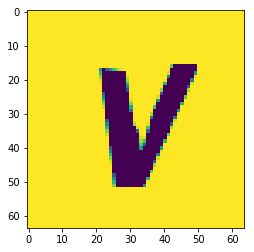

0.00038954574847593904 1.036345129416342e-05 0.0003903629191122822
Epoch 84: 1.572421908378601 0.7142634391784668 3.725290298461914e-08 0.018394287675619125 0.09136717766523361 0.02395039238035679,-1.5633976459503174


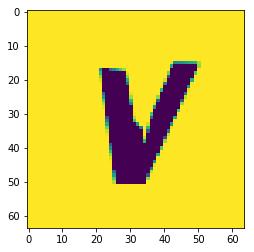

0.0006745688733644783 1.3874826464643775e-05 0.0003828418012451114
Epoch 85: 1.5169095993041992 -0.8496339321136475 1.2665987014770508e-07 0.019994040951132774 0.09134690463542938 0.023950332775712013,-1.5631396770477295


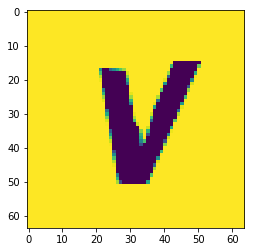

0.00040998775511980057 1.0977143875360676e-05 0.0003870056238409377
Epoch 86: 1.5585403442382812 -0.3473479449748993 5.960464477539063e-08 0.017452659085392952 0.09139770269393921 0.02395043522119522,-1.5628488063812256


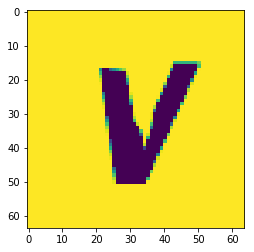

0.00017764615768101066 9.6901589661987e-06 0.0004011515651018982
Epoch 87: 1.608903169631958 -2.2086970806121826 2.2351741790771484e-08 0.019720207899808884 0.09128235280513763 0.023950504139065742,-1.5625677108764648


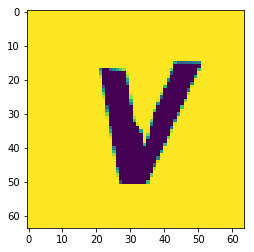

0.0001821805926738307 9.821134779504822e-06 0.00038741825700766563
Epoch 88: 1.5280749797821045 0.5520428419113159 6.705522537231445e-08 0.0182822123169899 0.09141993522644043 0.023949718102812767,-1.5622568130493164


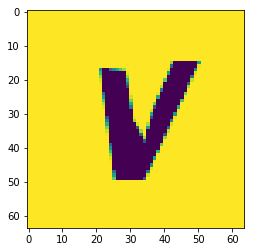

0.0001702659938018769 9.71234214356779e-06 0.0003902606947592628
Epoch 89: 1.540946364402771 -2.5359418392181396 4.6566128730773926e-08 0.017994163557887077 0.09141423553228378 0.023950137197971344,-1.5619392395019531


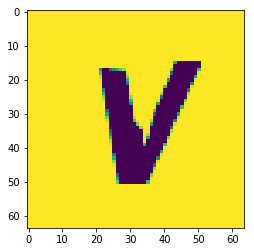

0.00021886028116568923 1.0069070834598884e-05 0.00039141411940076437
Epoch 90: 1.5694048404693604 -1.3498220443725586 7.450580596923828e-08 0.019213246181607246 0.09143172204494476 0.02395007014274597,-1.5616512298583984


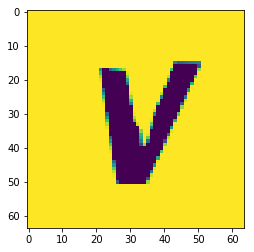

0.00033276795875281096 1.111469531167586e-05 0.00039549852628328885
Epoch 91: 1.568005919456482 0.540112316608429 7.450580596923828e-08 0.018475664779543877 0.0912453755736351 0.023950185626745224,-1.5613330602645874


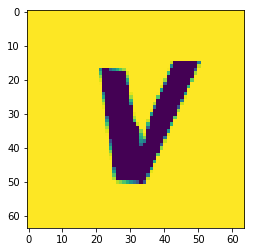

0.0005028869491070509 1.2659254765641966e-05 0.0003888741148236156
Epoch 92: 1.5342791080474854 0.9582873582839966 2.2351741790771484e-08 0.019641276448965073 0.09141625463962555 0.02394995093345642,-1.5610356330871582


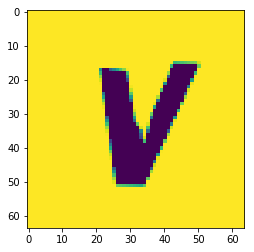

0.00048376433551311493 1.2205588343287369e-05 0.00039511384330133864
Epoch 93: 1.571165680885315 0.10733024775981903 2.9802322387695312e-08 0.017402581870555878 0.0914580449461937 0.023949822410941124,-1.5606908798217773


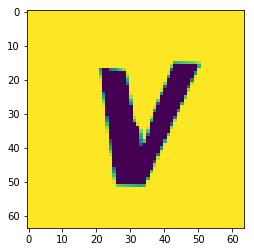

0.00028049806132912636 1.0800047139269964e-05 0.0003926903231428562
Epoch 94: 1.548253059387207 -1.93698251247406 1.862645149230957e-08 0.01904415711760521 0.09136436879634857 0.023950079455971718,-1.5603671073913574


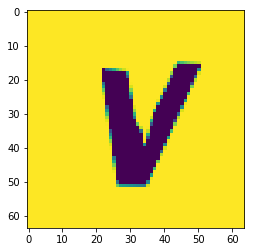

0.00035283830948174 1.1579556980242009e-05 0.00038613864404809145
Epoch 95: 1.5158157348632812 -2.9487318992614746 -7.450580596923828e-09 0.019000405445694923 0.09132393449544907 0.023949822410941124,-1.5600064992904663


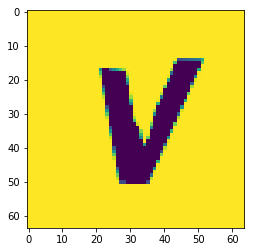

0.0005287080421112478 1.370277944801046e-05 0.0003981465360703244
Epoch 96: 1.5701632499694824 -0.043222665786743164 -4.470348358154297e-08 0.019016388803720474 0.09154407680034637 0.023950040340423584,-1.5596413612365723


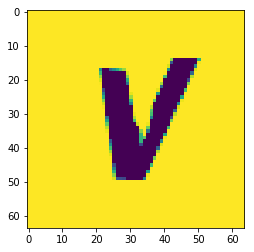

0.00025662261759862304 1.1585684970801443e-05 0.0004018423733252637
Epoch 97: 1.5832804441452026 -2.249629020690918 1.4901161193847656e-08 0.018747469410300255 0.09149562567472458 0.023949766531586647,-1.559314250946045


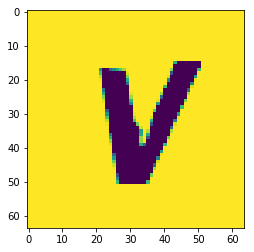

0.00014932863996364176 1.176189084025244e-05 0.0004101012867859429
Epoch 98: 1.6162545680999756 0.7008324861526489 5.21540641784668e-08 0.01878487691283226 0.09158243238925934 0.02394970692694187,-1.558884859085083


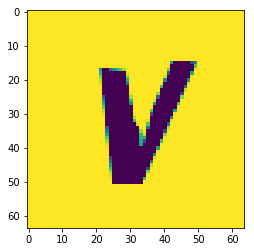

0.0003046157071366906 1.2258128087694331e-05 0.00039569934157276016
Epoch 99: 1.5381603240966797 -3.864898443222046 4.0978193283081055e-08 0.019263895228505135 0.09157001972198486 0.023949570953845978,-1.5585026741027832


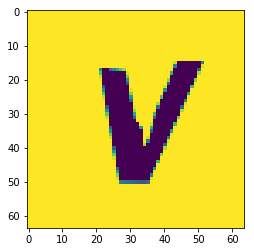

0.0003265546984039247 1.227110161513186e-05 0.0003983711234823624
Epoch 100: 1.5566869974136353 -1.1267260313034058 -7.450580596923828e-09 0.01763833314180374 0.09132581949234009 0.023949192836880684,-1.5581282377243042


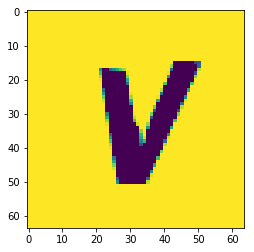

0.00028441642643883824 1.2188073450640028e-05 0.00039256864971304317
Epoch 101: 1.5280673503875732 0.6173598766326904 -5.960464477539063e-08 0.017406390979886055 0.0914861187338829 0.023949580267071724,-1.5576938390731812


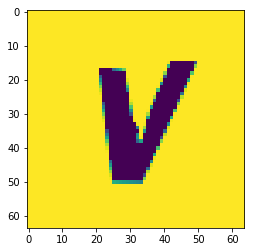

0.00014407941489480436 1.1947329773202378e-05 0.0003985726285650933
Epoch 102: 1.5482048988342285 -1.204088807106018 -2.9802322387695312e-08 0.018059147521853447 0.09126138687133789 0.023949453607201576,-1.5572738647460938


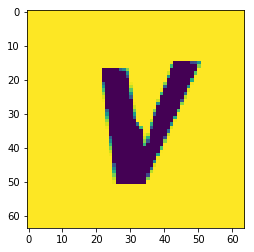

0.00013254969962872565 1.2511813759867133e-05 0.0004012249147295662
Epoch 103: 1.5593327283859253 0.0691291093826294 3.725290298461914e-08 0.01920994184911251 0.09158023446798325 0.02394941821694374,-1.5568830966949463


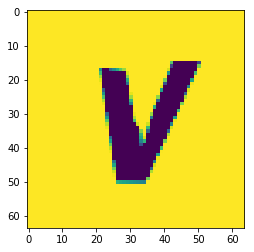

0.0001546473358757794 1.2326693227038277e-05 0.0003955006878860005
Epoch 104: 1.5260359048843384 -5.822074890136719 -1.1175870895385742e-08 0.01927242986857891 0.09139209985733032 0.02394944801926613,-1.5564486980438232


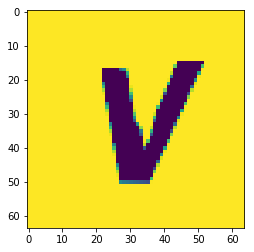

0.00012968177907168865 1.225255660723216e-05 0.00039002375245219173
Epoch 105: 1.4984947443008423 0.022519946098327637 5.960464477539063e-08 0.018709661439061165 0.09134819358587265 0.02394977957010269,-1.5559451580047607


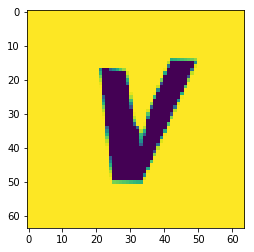

0.0004397517768666148 1.4347104539069733e-05 0.0004104590033414309
Epoch 106: 1.5970221757888794 1.1838923692703247 -1.4901161193847656e-08 0.01727168634533882 0.09136509895324707 0.023949431255459785,-1.555485486984253


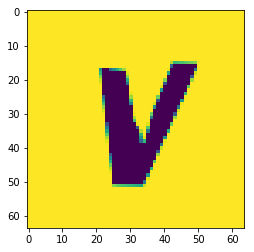

0.00010571340681053698 1.3247654102599427e-05 0.00039751426831139786
Epoch 107: 1.5182970762252808 -1.5246902704238892 4.470348358154297e-08 0.01922435127198696 0.09158496558666229 0.023949939757585526,-1.5550297498703003


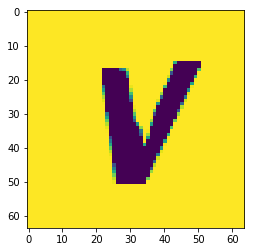

0.0005672015249729156 1.564452254617284e-05 0.00039641043184716435
Epoch 108: 1.5042216777801514 0.49501603841781616 -4.470348358154297e-08 0.019992658868432045 0.09135101735591888 0.023949861526489258,-1.5545337200164795


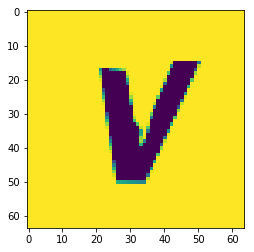

7.034502050373703e-05 1.3317137954752903e-05 0.0003934195291930287
Epoch 109: 1.4927889108657837 -0.7572165131568909 2.9802322387695312e-08 0.018194258213043213 0.09144877642393112 0.023949630558490753,-1.5540651082992554


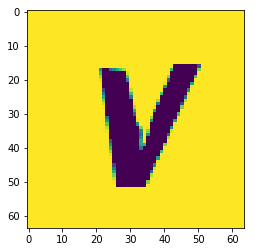

0.0002768288250081241 1.502503779941359e-05 0.00039813045722251567
Epoch 110: 1.5218393802642822 0.6047828197479248 1.4901161193847656e-08 0.018581371754407883 0.09156843274831772 0.023949826136231422,-1.553483009338379


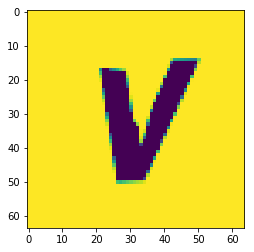

0.00022946626995690167 1.4743757081584855e-05 0.00041004605763609686
Epoch 111: 1.5652319192886353 -2.4351882934570312 4.470348358154297e-08 0.018293077126145363 0.09139382839202881 0.023949813097715378,-1.5529435873031616


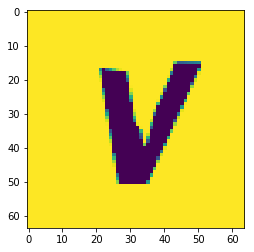

0.00025147644919343293 1.496344071938438e-05 0.0004026257519356702
Epoch 112: 1.5305806398391724 -0.966873288154602 2.9802322387695312e-08 0.018521640449762344 0.09139186143875122 0.02394982986152172,-1.5524801015853882


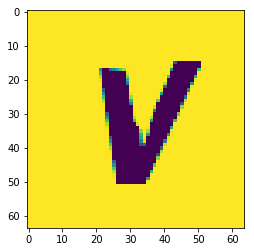

0.00017917549121193588 1.4965546981215994e-05 0.0004021842283217965
Epoch 113: 1.5331718921661377 2.2173707485198975 4.470348358154297e-08 0.019094455987215042 0.09130384773015976 0.023950120434165,-1.5519359111785889


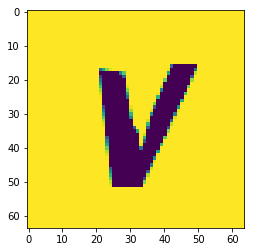

0.00014401046792045236 1.550966067812946e-05 0.0004047941258255028
Epoch 114: 1.5318275690078735 0.7573002576828003 -2.9802322387695312e-08 0.01838652417063713 0.09140267223119736 0.023950006812810898,-1.5513134002685547


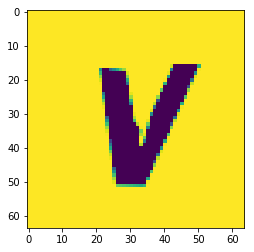

0.000301861873595044 1.666352302957345e-05 0.00040110107926231525
Epoch 115: 1.5139968395233154 -0.6527942419052124 1.4901161193847656e-08 0.01911989226937294 0.09165124595165253 0.023949982598423958,-1.5506576299667358


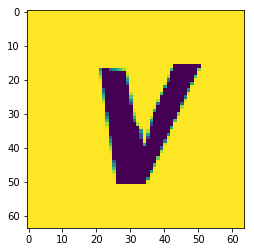

0.00022776771220378578 1.6569049459273327e-05 0.00041166419344969746
Epoch 116: 1.5543476343154907 1.97709321975708 4.284083843231201e-08 0.019093433395028114 0.09140589833259583 0.023949870839715004,-1.5500519275665283


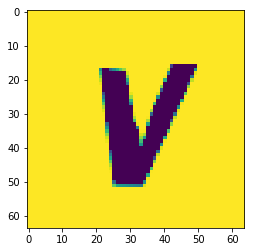

0.0003552138223312795 1.7461776717908606e-05 0.00041120247436365887
Epoch 117: 1.55857515335083 -4.652106285095215 7.450580596923828e-09 0.017516447231173515 0.09152539819478989 0.023950232192873955,-1.5493478775024414


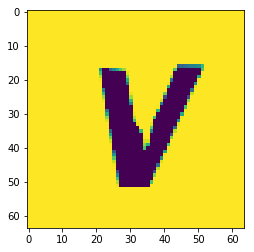

0.00018420636479277164 1.7740529213957263e-05 0.00041607465037030167
Epoch 118: 1.5775192975997925 1.0924140214920044 -2.60770320892334e-08 0.01745769940316677 0.09144717454910278 0.02395021542906761,-1.5486787557601929


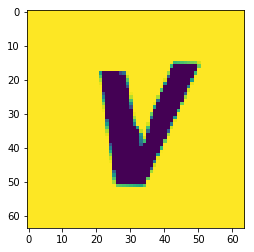

0.00020556845993269235 1.7924811947030623e-05 0.00040698089110557945
Epoch 119: 1.541869878768921 1.4330800771713257 4.470348358154297e-08 0.01910608820617199 0.09145452827215195 0.02395031601190567,-1.5479564666748047


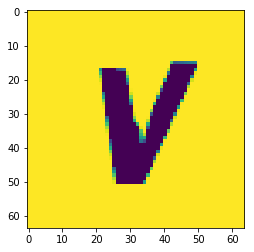

0.0001646154560148716 1.793939279555919e-05 0.00040212414792599
Epoch 120: 1.4936437606811523 -0.31970351934432983 -1.4901161193847656e-08 0.018537363037467003 0.09143616259098053 0.02395038492977619,-1.5471742153167725


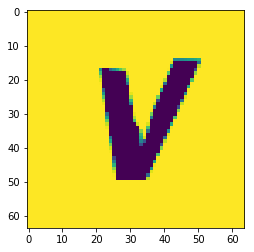

8.589585922891274e-05 1.805413501543285e-05 0.00040166117377415933
Epoch 121: 1.477007508277893 0.6426280736923218 -2.9802322387695312e-08 0.01990605518221855 0.09144028276205063 0.02395038492977619,-1.5465278625488281


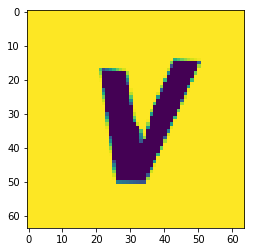

0.00021285451657604426 1.9449126639869974e-05 0.000418874316796584
Epoch 122: 1.5607632398605347 -1.4188194274902344 6.332993507385254e-08 0.01953471451997757 0.0914447009563446 0.023950600996613503,-1.5457050800323486


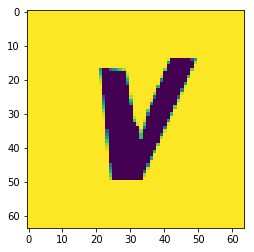

0.0002432610490359366 2.0445817648114446e-05 0.00042242956583860014
Epoch 123: 1.5875837802886963 -2.7019662857055664 3.725290298461914e-09 0.017990225926041603 0.0914391428232193 0.023950567469000816,-1.5448119640350342


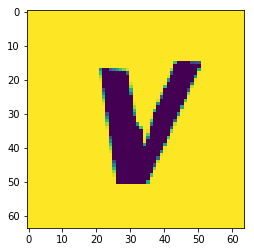

0.0002558603882789612 2.0687173884444594e-05 0.00041003252235090787
Epoch 124: 1.517457365989685 1.1663960218429565 -3.3527612686157227e-08 0.019431473687291145 0.09156887233257294 0.023950424045324326,-1.5438652038574219


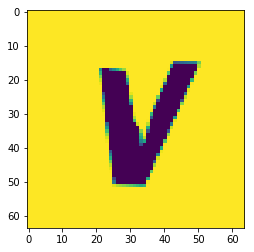

0.0002976945834234357 2.1330750143988553e-05 0.00041736340800128485
Epoch 125: 1.5393975973129272 -0.661771833896637 -2.9802322387695312e-08 0.018363412469625473 0.09128665924072266 0.02395058050751686,-1.5431898832321167


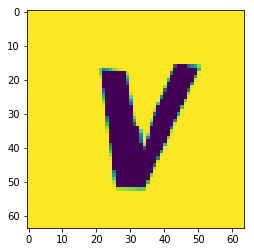

0.000522288610227406 2.242999136825574e-05 0.00040780279981881645
Epoch 126: 1.4871580600738525 2.0462257862091064 5.960464477539063e-08 0.019373809918761253 0.09127216786146164 0.023950519040226936,-1.5421881675720215


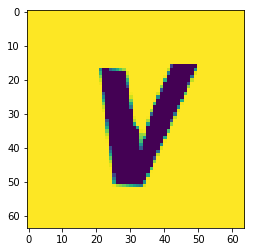

0.0004924368113279343 2.3496056509012913e-05 0.0004127239835558516
Epoch 127: 1.5107660293579102 -2.4601705074310303 0.0 0.019724315032362938 0.09129314869642258 0.023950424045324326,-1.5410975217819214


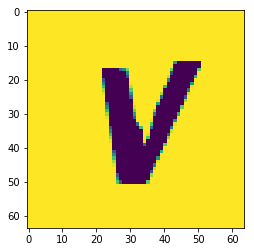

0.00013629520253743976 2.31171338202311e-05 0.0004098696450651751
Epoch 128: 1.486404538154602 -5.664463996887207 5.960464477539063e-08 0.018428655341267586 0.09171043336391449 0.02395017258822918,-1.5400514602661133


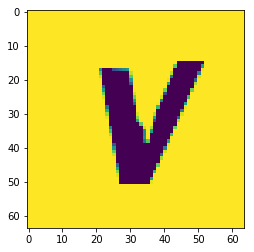

0.00017559752450324595 2.404476102431848e-05 0.00041973094281477774
Epoch 129: 1.5345168113708496 -1.6169008016586304 5.21540641784668e-08 0.018698465079069138 0.09138010442256927 0.023950519040226936,-1.5390986204147339


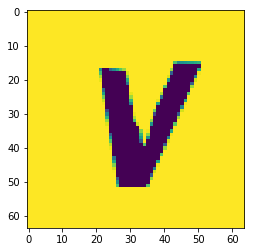

0.0004929127171635628 2.531639992871722e-05 0.0004175485998375213
Epoch 130: 1.5299550294876099 0.7402362823486328 -4.470348358154297e-08 0.020330695435404778 0.09124676883220673 0.023950161412358284,-1.5379915237426758


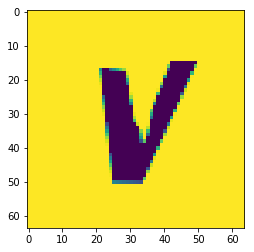

0.0002108233456965536 2.5569921917896938e-05 0.0004127526372682914
Epoch 131: 1.5105849504470825 0.9757373332977295 -5.960464477539063e-08 0.018532786518335342 0.0914955884218216 0.02395005151629448,-1.536673903465271


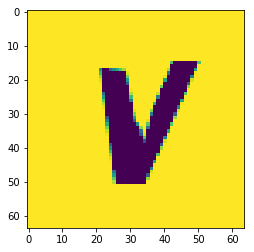

0.00024718380882404745 2.7187194452456726e-05 0.00042670245174299587
Epoch 132: 1.5635159015655518 0.9587148427963257 3.725290298461914e-08 0.0197974294424057 0.09150784462690353 0.023949570953845978,-1.53558349609375


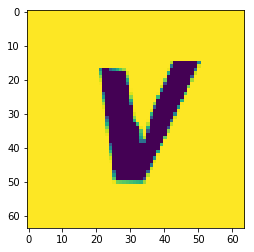

9.596630115993321e-05 2.831866977004438e-05 0.0004340226451442497
Epoch 133: 1.5855066776275635 -0.9377292990684509 2.60770320892334e-08 0.018533535301685333 0.09156107902526855 0.023949652910232544,-1.5340840816497803


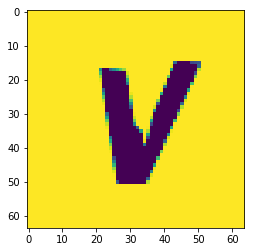

0.00016166198474820703 2.9187924039793717e-05 0.00043123021538971074
Epoch 134: 1.5660176277160645 1.4575895071029663 5.21540641784668e-08 0.01760246604681015 0.09144552797079086 0.02394954115152359,-1.532682180404663


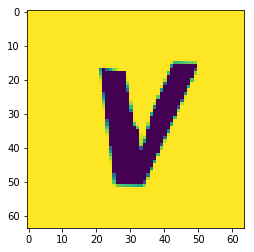

0.0004750267544295639 2.997478260861423e-05 0.0004140511371348854
Epoch 135: 1.4818127155303955 0.33927103877067566 7.82310962677002e-08 0.018392160534858704 0.09128882735967636 0.023949546739459038,-1.5312979221343994


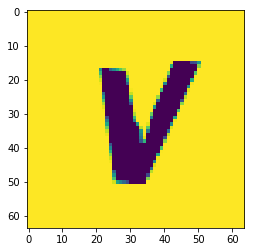

9.655642497818917e-05 3.079964339628797e-05 0.00042259047442494424
Epoch 136: 1.5112979412078857 1.5389889478683472 -3.725290298461914e-08 0.018788475543260574 0.09145637601613998 0.023949414491653442,-1.5296697616577148


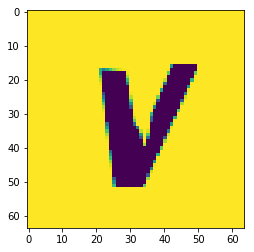

0.00023800699273124337 3.313145758928234e-05 0.00042525986239161373
Epoch 137: 1.5288134813308716 -1.0083504915237427 2.9802322387695312e-08 0.018946826457977295 0.09168680012226105 0.023949023336172104,-1.5279964208602905


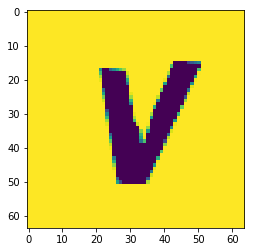

0.00023999839322641492 3.350145714501688e-05 0.00042352229579515715
Epoch 138: 1.4953211545944214 1.3112599849700928 -5.960464477539063e-08 0.019683513790369034 0.09141175448894501 0.023949231952428818,-1.5260837078094482


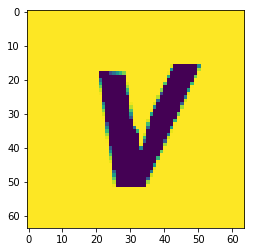

0.0003769095055758953 3.513616228545402e-05 0.00041926722485045403
Epoch 139: 1.48134183883667 -1.4487428665161133 3.725290298461914e-08 0.018480118364095688 0.09146495163440704 0.023949099704623222,-1.52447509765625


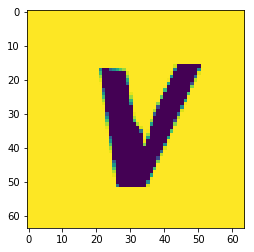

4.779649316333234e-05 3.664011847230123e-05 0.000425107559589281
Epoch 140: 1.4919203519821167 -0.7775877714157104 -2.9802322387695312e-08 0.018560899421572685 0.09168575704097748 0.023948807269334793,-1.5223510265350342


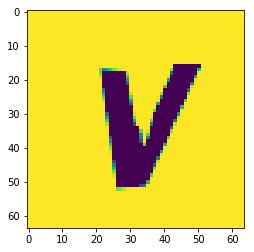

0.00031769732595421374 3.967997483063831e-05 0.00043267624020811485
Epoch 141: 1.539678692817688 0.3573960065841675 4.842877388000488e-08 0.0201251320540905 0.09165513515472412 0.023948444053530693,-1.5199470520019531


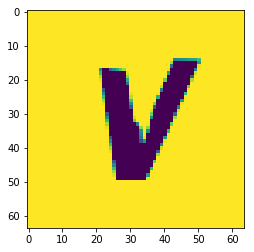

0.00013228622265160084 3.9307532258447964e-05 0.0004281588850544675
Epoch 142: 1.4961731433868408 1.7655978202819824 0.0 0.019426386803388596 0.09130601584911346 0.023948434740304947,-1.51796293258667


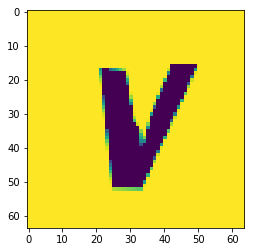

0.00037311954656615853 4.255379386582566e-05 0.0004324573692134903
Epoch 143: 1.5175423622131348 1.136125087738037 2.2351741790771484e-08 0.01942400261759758 0.09145325422286987 0.023948263376951218,-1.5155963897705078


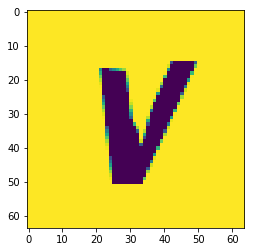

0.00013108723214827478 4.318830734935849e-05 0.000424356565540777
Epoch 144: 1.456153154373169 0.27836450934410095 5.21540641784668e-08 0.018500788137316704 0.09143476188182831 0.023947929963469505,-1.5127859115600586


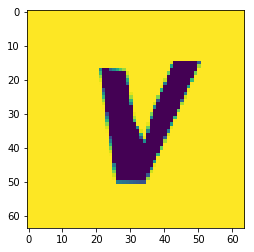

0.0005175578990019858 4.710061684913095e-05 0.00043181199364876005
Epoch 145: 1.5014859437942505 1.255084753036499 -7.450580596923828e-09 0.019759170711040497 0.0914103239774704 0.02394779585301876,-1.5100873708724976


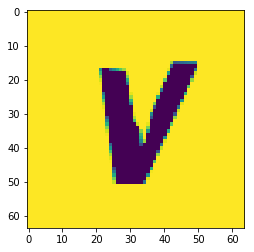

4.458136027096771e-05 4.837316488703891e-05 0.000432994728751616
Epoch 146: 1.4937450885772705 0.6520676612854004 2.2351741790771484e-08 0.01772383041679859 0.09141066670417786 0.023947391659021378,-1.5069739818572998


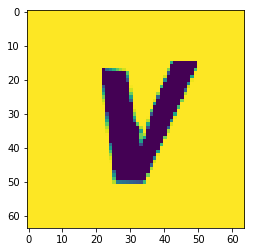

0.0003710987512022257 5.2545775472386445e-05 0.00043781554838458653
Epoch 147: 1.5004030466079712 1.5671753883361816 1.4901161193847656e-08 0.01754140853881836 0.09174785017967224 0.023947523906826973,-1.5034725666046143


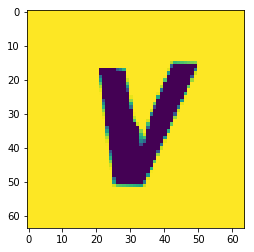

0.00015563108900096267 5.3865278019316065e-05 0.0004383890648413935
Epoch 148: 1.5089147090911865 2.0919079780578613 -1.4901161193847656e-08 0.01787024736404419 0.09111493080854416 0.02394700050354004,-1.499754786491394


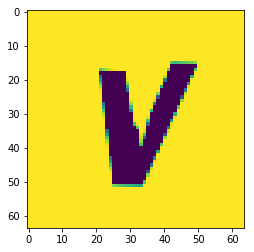

0.00028619763907045126 5.7221643992022564e-05 0.0004326762480362234
Epoch 149: 1.4724477529525757 -0.13738249242305756 8.195638656616211e-08 0.018723178654909134 0.09138604253530502 0.023946866393089294,-1.495536208152771


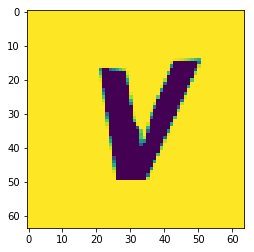

In [53]:
agent = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
opt_agent = torch.optim.Adam(agent.parameters(),lr=1e-4,weight_decay=0.01)
action_mask = [torch.ByteTensor([1]*len(tool_dict[data.vocab[i]]) + [0]*(4-len(tool_dict[data.vocab[i]]))) for i in range(len(data.vocab))]
action_mask = torch.stack(action_mask).cuda()

with torch.autograd.detect_anomaly():
    for epoch in range(150):
        state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
        action_log_probs, pen_log_probs, rewards, actions, mses, entropy_a, entropy_p = [], [], [], [], [], [], []
        baseline = F.mse_loss(start_state,targets,reduction="none").view(start_state.shape[0],-1).mean(dim=1)
        seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
        for t in range(3):
            npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask)
            seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
            #print(state_pens-npens)
            state_pens = npens
            #print(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            #state = nparallel(render_paths(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            state = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))).unsqueeze(1).cuda()
            mse = F.mse_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1)
            reward = baseline - mse
            baseline = mse
            action_log_probs.append(action_probs)
            pen_log_probs.append(pen_probs)
            rewards.append(reward)
            actions.append(action.detach())
            mses.append(mse)
            entropy_a.append(action_entropy)
            entropy_p.append(pen_entropy)

        action_log_probs = torch.stack(action_log_probs,dim=1)
        pen_log_probs = torch.stack(pen_log_probs,dim=1)
        rewards = torch.stack(rewards,dim=1)
        rewards = (rewards - rewards.mean()) / rewards.std()
        actions = torch.stack(actions,dim=1)
        mses = torch.stack(mses,dim=1)
        entropy_a = torch.stack(entropy_a,dim=1)
        entropy_p = torch.stack(entropy_p,dim=1)
        tool = torch.gather(state_tools,1,actions)
        #print(rewards.shape)
        ##print(rewards)
        #rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
        #print(action_log_probs.shape,pen_log_probs.shape,rewards.shape)
        #loss = (rewards * action_log_probs).mean() + 100*(rewards.unsqueeze(-1) * pen_log_probs)[action_mask[tool]].mean()
        #loss = -100*(rewards.unsqueeze(-1) * pen_log_probs)[action_mask[tool]].mean()
        loss = (rewards.unsqueeze(-1) * pen_log_probs)
        loss[~action_mask[tool]] = 0.0
        loss = loss.mean()
        loss = loss + (rewards * -action_log_probs).mean() - 0.01*entropy_a.mean() - entropy_p.mean()
        opt_agent.zero_grad()
        loss.backward()
        rnn_grads,mdn_grads = [],[]
        for p in agent.path_encoder.parameters():
            if p.grad is not None: rnn_grads.append(p.grad.abs().mean().item())
        for p in agent.adjust.parameters():
            if p.grad is not None: mdn_grads.append(p.grad.abs().mean().item())
        print(agent.tool_sel.weight.grad.abs().mean().item() if agent.tool_sel.weight.grad is not None else "",np.mean(rnn_grads),np.mean(mdn_grads))
        opt_agent.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: {loss.item()} {rewards[0].sum().item()} {rewards.sum(dim=1).mean().item()} {mses[:,-1].mean().item()} {action_log_probs.exp().mean().item()} {0.01*entropy_a.mean()},{entropy_p.mean()}")
            plt.imshow(state[0,0])
            plt.show()

In [30]:
class RectifyTransformer(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int,
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True, tool_emb_sd=None):
        super().__init__()
        self.mask = mask
        self.tool_emb = nn.Embedding(len(data.vocab),4)
        if tool_emb_sd is not None:
            self.tool_emb.load_state_dict(tool_emb_sd)
        #self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop,
                      attn_cls=attn_cls) for k in range(n_layers)])
        self.out = nn.Linear(9,4)

    def reset(self): pass

    def forward(self, tools, pens):
        bs, x_len, pen_size = pens.size()
        pos = torch.arange(0, x_len, device=pens.device, dtype=pens.dtype)
        tools = self.tool_emb(tools)
        inp = torch.cat([pos.view(1,-1,1).expand(bs,-1,-1),tools,pens],dim=2)
        mask = torch.triu(pens.new_ones(x_len, x_len), diagonal=1).byte()[None,None] if self.mask else None
        #[None,:,:None] for einsum implementation of attention
        for layer in self.layers: inp = layer(inp, mask=mask)
        return pens + torch.tanh(self.out(inp))
        #return ([inp],[inp]) #For the LinearDecoder
        
class RectifyTrainer(LearnerCallback):
    def on_batch_begin(self, last_input, last_target, **kwargs):
        learnSVG.model.eval()
        with torch.no_grad():
            tools, pens = learnSVG.model.get_preds(last_input,last_target[2])
            
        return {"last_input": (tools,pens), "last_target": last_target[1]}

def rectify_loss(preds,target):
    target = target[:,1:200]
    mask = (target != -2.0)
    loss = F.mse_loss(preds[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
    return loss

In [166]:
t = RectifyTransformer(62,5,6,4,1+4+4,32,64,learned_pos_enc=False,tool_emb_sd=learnSVG.model.token_emb.state_dict())
learnRectify = Learner(data,t,loss_func=rectify_loss,callback_fns=[RectifyTrainer])

In [167]:
learnRectify.fit(20,3e-3)

epoch,train_loss,valid_loss,time
0,0.033348,#na#,00:25
1,0.025710,#na#,00:25
2,0.023460,#na#,00:25
3,0.022415,#na#,00:25
4,0.021936,#na#,00:25
5,0.021703,#na#,00:25
6,0.021709,#na#,00:25


KeyboardInterrupt: 

In [160]:
t(torch.randint(0,len(data.vocab),(32,50)),torch.randn(32,50,4)).shape

torch.Size([32, 50, 4])

In [91]:
class ConvBlock(nn.Module):
    def __init__(self,in_size,out_size,stride=1,final_relu=True):
        super().__init__()
        self.out_size = out_size
        self.final_relu = final_relu
        self.conv = nn.Sequential(
                       conv2d(in_size,out_size,ks=(7,1),stride=(stride,1),padding=(3,0),bias=False),
                       nn.ReLU(inplace=True),
                       conv2d(out_size,out_size,ks=(7,1),stride=1,padding=(3,0),bias=False))
        self.shortcut = conv2d(in_size,out_size,ks=(1,1),stride=(stride,1),padding=(0,0),bias=False)
        
    def forward(self, x):
        u = self.conv(x)
        
        if x.shape[1] != self.out_size:
            x = self.shortcut(x)
            
        x = x + u
        if self.final_relu:
            x = F.relu(x)
        return x


class RectifyNet(nn.Module):
    def __init__(self,tool_size,tool_emb_sd=None):
        super().__init__()
        self.tool_emb = nn.Embedding(tool_size,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        requires_grad(self.tool_emb,False)
        blocks = [1,16,32,16,1]
        self.conv = nn.Sequential(*[ConvBlock(i,o,1) for i,o in zip(blocks,blocks[1:])])
        self.mdn = MDN(8,4,32,use_sigmoid=True)
        
    def forward(self, tools, pens):
        #pens bs x seq x 4
        #tokens bs x seq
        u = torch.cat([self.tool_emb(tools),pens],dim=2)
        u = u.unsqueeze(1)
        u = self.conv(u)
        return self.mdn(u.squeeze(1))

    
class UpBlock(nn.Module):
    def __init__(self,up_in,c_in):
        super().__init__()
        self.conv_up = conv2d_trans(up_in,c_in,ks=(3,1),stride=(2,1),padding=(1,0))
        self.conv = nn.Sequential(conv_layer(c_in*2,c_in),conv_layer(c_in,c_in,use_activ=False))
        
    def forward(self, x, c):
        u = self.conv_up(x)
        u = torch.cat([u,c],dim=1)
        return self.conv(u)
        
    
class RectifyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_blocks = [1,8,16,32]
        self.encoder = nn.ModuleList([ConvBlock(i,o,2) for i,o in zip(encoder_blocks,encoder_blocks[1:])])
        
        self.middle_conv = nn.Sequential(conv_layer(32,64),conv_layer(64,32))
        
        decoder_blocks = [32,16,8,1]
        self.decoder = nn.ModuleList([UpBlock(i,o) for i,o in zip(decoder_blocks,decoder_blocks[1:])])
        
        
    def forward(self, pens): 
        u = pens.unsqueeze(1)
        outputs = [u]
        for l in self.encoder:
            u = l(u)
            outputs.append(u)
            
        u = self.middle_conv(u)
        
        for o,l in zip(reversed(outputs[:-1]),self.decoder):
            u = l(u,o)
            
        return pens + u.squeeze(1)

class RectifyRNN(nn.Module):
    def __init__(self,tool_size,tool_emb_sd=None):
        super().__init__()
        self.cnn = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,128,5,1,2),
            nn.InstanceNorm2d(128,affine=True),
            nn.ReLU(),
            conv2d(128,256,5,2,2),
            nn.InstanceNorm2d(256,affine=True),
            nn.ReLU(),
            conv2d(256,512,3,2,1))
        self.flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1),Flatten())
            
        self.tool_emb = nn.Embedding(tool_size,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        requires_grad(self.tool_emb,False)
        #self.rnn = nn.LSTM(8,1024,3,batch_first=True)
        self.rnn = AWD_LSTM(62,512+8,1024,3,0,input_p=0.0)
        self.sv_to_hs = nn.Linear(512,1024)
        #self.out = nn.Sequential(nn.Linear(128,32),nn.ReLU(),nn.Linear(32,4))
        self.out = MDN(1024,4,32,scale=0.025)
                
    def forward(self, tools, pens, target):
        sv = self.flatten(self.cnn(target))
        
        u = torch.cat([sv.unsqueeze(1).expand(-1,tools.shape[1],-1),self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(sv).unsqueeze(0).expand(3,-1,-1)
        output,_ = self.rnn(u,(hs,torch.zeros_like(hs)),from_embeddings=True)
        pi,sigma,mu = self.out(output)
        
        sigma = sigma
        return (pi,sigma,mu)
        
class RectifyTrainer(LearnerCallback):
    _order = -20
    
    def on_train_begin(self, **kwargs):
        self.smoothMSE = SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["mse"])
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        learnSVG.model.eval()
#         with torch.no_grad():
#             tools, pens = learnSVG.model.get_preds(last_input,last_target[2])
        
        noise = torch.zeros_like(last_target[1]).normal_(0.0,0.01)
        self.pens = last_target[1]
        return {"last_input": (last_target[0],last_target[1]+noise,last_input), "last_target": (-noise,last_target[1])}
    
#     def on_step_end(self, last_loss, last_output, **kwargs):
#         if torch.isnan(self.learn.model.conv[0].conv[0].weight.grad).sum() > 0:
#             print(last_loss)
#             print([torch.isnan(m).sum() for m in last_output])
#             return {"stop_epoch": True, "stop_training": True}
        
       
    def on_batch_end(self, last_output, last_target, **kwargs):
        s = sample(*last_output)
        s = s + self.pens
        target = last_target[1][:,1:200]
        mask = (target != -2.0)
        mse = F.mse_loss(s[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
        self.smoothMSE.add_value(mse.item())

        #self.smoothMSE.add_value(0.0)
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothMSE.smooth])
    


# def rectify_loss(preds,target):
#     target = target[:,1:200]
#     mask = (target != -2.0)
#     loss = F.mse_loss(preds[:,1:target.shape[1]+1],target,reduction="none")[mask].mean()
#     return loss

def mdn_loss2(pi, sigma, mu, target, target_pens):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    ntarget = target.unsqueeze(-1)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(ntarget))
    loss = torch.sum(loss * pi, dim=3)
    bl = loss
    loss = -torch.log(loss+1e-8)
    if torch.isnan(loss).sum() > 0:
        print(loss)
    loss = loss[target_pens != -2.0]
    return loss.mean()

def rectify_loss(preds,target,target_pens):
    target = target[:,1:200]
    target_pens = target_pens[:,1:200]
    preds = [p[:,1:target.shape[1]+1] for p in preds]
    return mdn_loss2(*preds,target,target_pens)

In [94]:
learnRectify = Learner(data,RectifyRNN(len(data.vocab),learnSVG.model.token_emb.state_dict()),loss_func=rectify_loss,callback_fns=[RectifyTrainer])

In [95]:
learnRectify.fit_one_cycle(100,3e-3)

epoch,train_loss,valid_loss,mse,time
0,0.638876,#na#,0.726301,00:03
1,-0.954234,#na#,0.337506,00:03
2,-1.914660,#na#,0.185274,00:03
3,-2.400837,#na#,0.113227,00:03
4,-2.675149,#na#,0.073148,00:03
5,-2.844872,#na#,0.048816,00:03
6,-2.952019,#na#,0.033250,00:03
7,-3.021652,#na#,0.022955,00:03
8,-3.068507,#na#,0.015997,00:03
9,-3.099914,#na#,0.011223,00:03


Exception ignored in: <function _releaseLock at 0x7fb9869f96a8>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
Process Process-5118:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 132, in _run_after_forkers
    func(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 76, in _after_fork
    self._send_bytes = self._writer.send_bytes
KeyboardInterrupt


KeyboardInterrupt: 

In [90]:
learnRectify.fit_one_cycle(10,3e-5)

epoch,train_loss,valid_loss,mse,time


KeyboardInterrupt: 

In [65]:
learnRectify.save("rectify")

In [66]:
m = RectifyRNN(len(data.vocab),learnSVG.model.token_emb.state_dict())
m.load_state_dict(learnRectify.model.state_dict())
learnDRectify = Learner(data,m,loss_func=rectify_loss,callback_fns=[partial(DoubleRectifyTrainer,old_model=learnRectify.model)])

In [67]:
learnDRectify.fit_one_cycle(1,3e-4)

epoch,train_loss,valid_loss,mse,time


tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         

RuntimeError: copy_if failed to synchronize: device-side assert triggered

In [159]:
def get_pred_path_rect(x,labels,mean=False):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
    pens = learnRectify.model(pens)
    out = []
    for t,p in zip(tools[0,1:-1],pens[0,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [160]:
def get_pred_path_both(x,labels,mean=False,i=0):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)

    out = []
    for t,p in zip(tools[i,1:-1],pens[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    norect = " ".join(out)
    
    pens2 = learnRectify.model(pens)
    out = []
    for t,p in zip(tools[i,1:-1],pens2[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    rect = " ".join(out)
    return norect, rect

In [161]:
x,y = next(iter(data.train_dl))
labels = y[2]

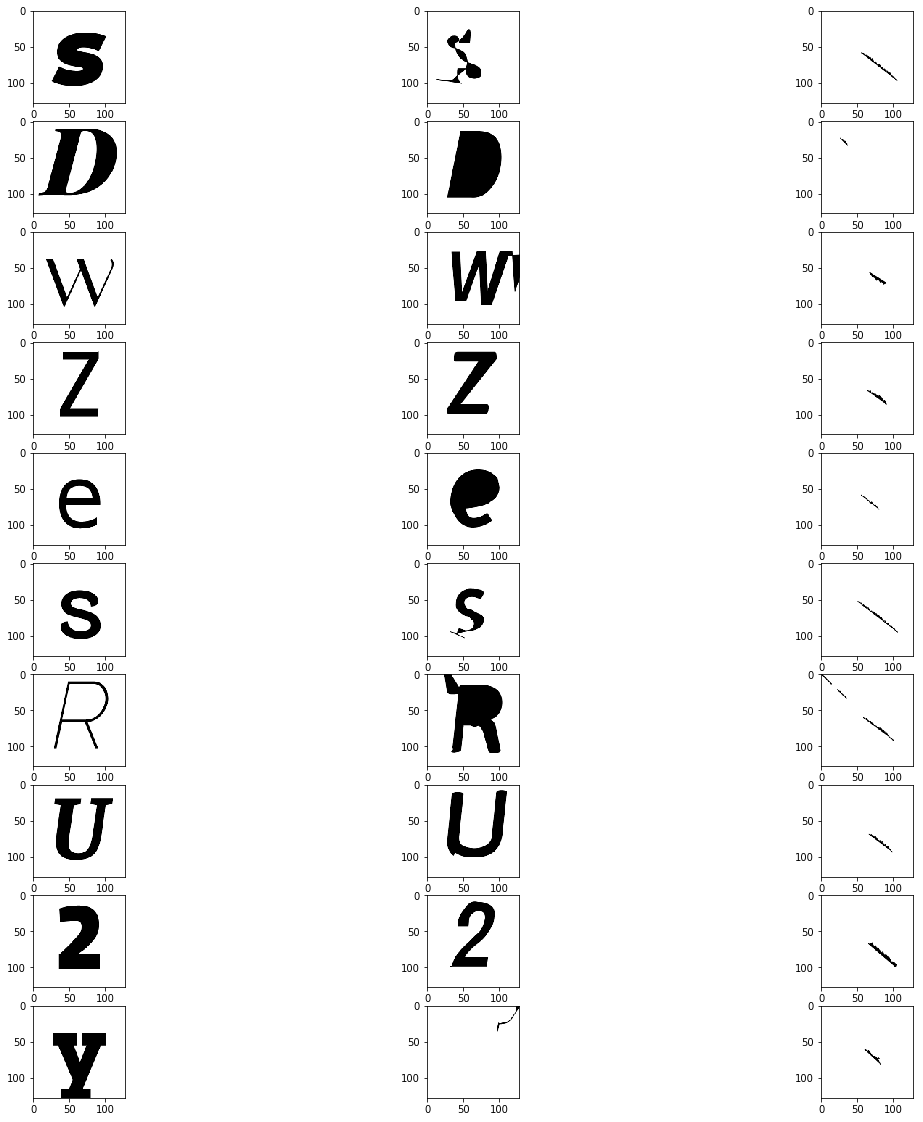

In [162]:
fig, axes = plt.subplots(10,3,figsize=(20,20))
for i in range(10):
    orig = render_path_wand(path_from_tensors(y[0],y[1],i),500,500)
    norect,rect = get_pred_path_both(x,labels,mean=True,i=i)
    #norect = norect[:len(orig)]
    #rect = rect[:len(orig)]
    norect = norect[:norect.find("END")-1]
    rect = rect[:rect.find("END")-1]
    norect = render_path_wand(norect,500,500)
    rect = render_path_wand(rect,500,500)
    axes[i,0].imshow(orig)
    axes[i,1].imshow(norect)
    axes[i,2].imshow(rect)

In [36]:
p_mean = get_pred_path_rect(x[[0]],labels[[0]],mean=True)
#p_mean = p_mean[:p_mean.find("z")+1]
p_mean = p_mean[:p_mean.find("END")-1]
#p_mean = p_mean[:len(po)]
p_mean

'M 291 330 q -8 45 -34 74 t -49 48 t -67 29 l -17 -53 q 23 -9 35 -20 t 19 -27 t 9 -36 l 41 -298 l 89 0 z  PAD  z  PAD '

In [37]:
render_path_wand(path_from_tensors(y[0],y[1]),500,500)

NameError: name 'path_from_tensors' is not defined

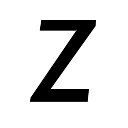

In [314]:
render_path_wand(p_mean,500,500)

In [49]:
class SVGDiscriminator(nn.Module):
    def __init__(self,num_tokens):
        super().__init__()
        self.token_emb = nn.Embedding(num_tokens,4)
        #self.rnn = nn.GRU(4+4,1024,4,batch_first=True,dropout=0.3)
        self.rnn = nn.LSTM(4+4,1024,4,batch_first=True,dropout=0.3)
        self.out = nn.Sequential(nn.Linear(1024,128),nn.ReLU(),nn.Linear(128,1))
               
        
    def forward(self, tokens, pen):
        tokens = self.token_emb(tokens)
        r_in = torch.cat([tokens,pen],dim=2)
        #self.rnn.flatten_parameters()
        output, (hs,cs) = self.rnn(r_in)
        
        return self.out(output[:,-1])
    
class NGAN(nn.Module):
    def __init__(self,generator,discriminator,num_classes=None):
        super().__init__()
        self.gen = generator
        self.disc = discriminator
        
    def forward(self, png, char_class,tokens, pen, return_preds=False):
        return self.gen(png, char_class,tokens, pen, return_preds)
    
def noop_loss(preds,target): return torch.tensor(0.0)

In [55]:
def clean_preds(p_tokens,p_pen,r_tokens,r_pen):
    p_tokens[:,:-1][r_tokens == 0] = 0
    p_pen[:,:-1][r_pen == -2.0] = -2.0
    return p_tokens,p_pen

class SVGGanTrainer(LearnerCallback):
    _order=-20
    
    def on_train_begin(self, **kwargs):
        self.learn.opt = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.disc))])
        self.opt_disc = self.learn.opt
        self.opt_gen = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.gen))])
        self.opt_gen.lr = 3e-4
        self.smoothenerG,self.smoothenerD,self.smoothenerMix,self.smoothenerReal = SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98)
        self.sublosses = ["g_d","gen_rec"]
        self.smoothDict = {sl: SmoothenValue(0.98) for sl in self.sublosses}
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'] + self.sublosses)
        self.m_labels = torch.eye(10).cuda()
        self.it = 0
        self.gen_loss = SVGDecoderLoss()
        #self.gen_copy = UpAE().cuda()
        #self.gen_copy.load_state_dict(self.learn.model.gen.state_dict())
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        requires_grad(self.learn.model.gen,False)
        requires_grad(self.learn.model.disc,True)
        self.learn.model.train()
        self.last_input = last_input
        self.last_target = last_target
        return {"last_input": (last_input, last_target[2], last_target[0], last_target[1],True),"last_target": 0}
    
    def on_backward_begin(self, train, last_input, last_output, last_target, **kwargs):
        if not train: return
        self.learn.model.disc.train()
        _,_,preds = last_output
        p_tokens,p_pen = clean_preds(*preds,self.last_target[0][:,1:],self.last_target[1][:,1:])
        fake_preds = self.learn.model.disc(p_tokens,p_pen)
        real_preds = self.learn.model.disc(self.last_target[0][:,1:],self.last_target[1][:,1:])
        
        losses = [F.relu(1.0-real_preds).mean(),F.relu(1.0+fake_preds).mean()]
        loss = sum(losses)
        self.opt_disc.zero_grad()
        loss.backward()
        self.opt_disc.step()
        self.smoothenerD.add_value(loss.item())
        return {"last_loss": loss, "skip_bwd": True}
    
    def on_backward_end(self, **kwargs):
        return {"skip_step": True}
        
    def on_batch_end(self, train, last_input, last_target, **kwargs):
        if not train: return
        #if self.it % 2 != 0: return
        requires_grad(self.learn.model.gen,True)
        requires_grad(self.learn.model.disc,False)
        self.learn.model.gen.train()
        
        tokens,pen,preds = self.learn.model.gen(*last_input)
        p_tokens,p_pen = clean_preds(*preds,self.last_target[0][:,1:],self.last_target[1][:,1:])
        lt = torch.argmax(self.last_target[0][0] == 0)
        self.last_mix = path_from_tensors(p_tokens[:,:lt],p_pen[:,:lt])
        fake_preds = self.learn.model.disc(p_tokens,p_pen)
        
        losses = [F.relu(1.0-fake_preds).mean(),self.gen_loss((tokens,pen),self.last_target[0][:,1:],self.last_target[1][:,1:])]
        loss = sum(losses)
        
    
        for l,sm in zip(losses,self.sublosses):
            self.smoothDict[sm].add_value(l.item())
            
        self.smoothenerG.add_value(loss.item())
        self.opt_gen.zero_grad()
        loss.backward()
        self.opt_gen.step()
        self.it += 1
        
        #self.gen_copy.load_state_dict(self.learn.model.gen.state_dict())

        
    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
        if epoch % 1 == 0:
            img = render_path_wand(self.last_mix,500,500)
            img.save(filename="gan_output.png")
            img = open_image("gan_output.png")
            if not hasattr(self,"imgs"):
                self.imgs = []
                self.titles = []
            self.imgs.append(img)
            self.titles.append(f"Epoch {epoch}")
            pbar.show_imgs(self.imgs,self.titles)

        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerD,'smooth',None)] + [self.smoothDict[sl].smooth for sl in self.sublosses])

In [56]:
gen = SVGDecoder(len(data.vocab),learnAE.model.state_dict())
disc = SVGDiscriminator(len(data.vocab))
gan = NGAN(gen,disc)
learnGAN= Learner(data,gan,loss_func=noop_loss,callback_fns=[SVGGanTrainer],opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [ ]:
learnGAN.fit(10,3-3)

epoch,train_loss,valid_loss,gen_loss,disc_loss,g_d,gen_rec,time
